In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math as ma
import seaborn as sns
import h5py
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from astropy import constants
from scipy import stats
from astropy.io import fits
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve

In [2]:
def df_key(x,y,z):
    return str('o'+str(int(x))+'t'+str(int(y))+'f'+str(int(z)))

def loc_key(x,y):
    return str('ra'+str(x)+'dec'+str(y))

### Read detected outlier data

def load_outliers_from_h5(file_path, polarizations):
    with h5py.File(file_path, "r") as f:
        outliers_mask = f["wins_z_score"][:]
        obs_id = f["obs_id"][:].astype(str)
        time_blocks = f["time_blocks"][:]

    print("Outliers: ", outliers_mask.shape)

    flat_data = outliers_mask.reshape(-1, outliers_mask.shape[-1])
    
    # Create DataFrame
    df_outliers = pd.DataFrame(flat_data, columns=["XX", "XY", "YX", "YY"])

    df_outliers["obs_id"] = np.tile(obs_id, outliers_mask.shape[1]*outliers_mask.shape[2])
    df_outliers["time_index"] = np.repeat(np.arange(outliers_mask.shape[0]), outliers_mask.shape[1] * outliers_mask.shape[2])
    df_outliers["frequency"] = np.tile(np.arange(outliers_mask.shape[2]), outliers_mask.shape[0] * outliers_mask.shape[1])
    df_outliers["antenna"] = np.tile(np.repeat(np.arange(outliers_mask.shape[1]), outliers_mask.shape[2]), outliers_mask.shape[0])
    df_outliers["obs_id"] = df_outliers['time_index'].map(lambda t: int(obs_id[t]))
    df_outliers["timeblock"] = df_outliers['time_index'].map(lambda t: int(time_blocks[t]))

    selected_polarizations = polarizations  

    # Filter rows where any of the selected columns is True
    df_outliers = df_outliers[df_outliers[selected_polarizations].any(axis=1)].reset_index(drop=True)

    return df_outliers

In [3]:
observation_file = "/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/observation_id/observation_id.csv"

df = pd.read_csv(observation_file, header=0, engine='python')
df = df[['obs_id', 'groupid', 'starttime_utc', 'local_sidereal_time_deg', 'duration',
        'int_time', 'freq_res', 'dataqualityname', 'bad_tiles', 'calibration',
        'calibration_delays', 'center_frequency_mhz', 'channel_center_frequencies_mhz_csv',
        'ra', 'ra_pointing', 'ra_phase_center', 'dec', 'dec_pointing', 'dec_phase_center',
        'deleted_flag', 'good_tiles', 'mode', 'sky_temp', 'stoptime_utc', 'total_tiles', 'gridpoint_name', 'gridpoint_number']]
df['date'] = df.starttime_utc.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.000Z").date())
df['partition'] = pd.factorize(df['date'])[0] + 1
df = df[df['partition'] == 1].reset_index(drop=True)

obs_list = df['obs_id'].to_list()
gn = np.unique(df['gridpoint_number'])

In [36]:
outlier_path = "/Volumes/eor_ssd_2/results_model_revision_251203/"
#outlier_path = "/Volumes/eor_hdd_2/results_model_revision_251128_5_5/"
added_rfi_path = "/Users/eormacstudio/Documents/winsorized_statistics/winsorizing_model_visibility/higher_thermal_noise/same_level_noise/"

threshold_type = ['negative', 'positive', 'combine']
polarizations = ["XX", "YY"]
parts = ["real", "imaginary", "amplitude", "phase"]
sn = ['sn1', 'sn5', 'sn3', 'sn4', 'sn2']
integ = ['8s', '2s']

level = ['901.59', '1298.45', '1620.04', '1906.17', '2176.54']
df_rfi_level = pd.DataFrame({'sn' : sn, 'level' : level})

time_convert = np.repeat(np.arange(0,14), 4)
tile_list = np.arange(0, 128, 1)
z_score = np.arange(2, 14, 1)

cal_pol_alias = pd.DataFrame({
    'pol': ['XX', 'XY', 'YX', 'YY']})
cal_pol_alias = cal_pol_alias.reset_index()

vis_pol_alias = pd.DataFrame({
    'pol': ['XX', 'YY', 'XY', 'YX']})
vis_pol_alias = vis_pol_alias.reset_index()

z_alias = pd.DataFrame({
    'z_score': z_score})
z_alias = z_alias.reset_index(drop=True)

In [5]:
df_stats = pd.DataFrame()

for i in range(len(parts)):
    for j in range(len(sn)):
        for k in range(1): #len(polarizations)):
            for l in range(len(integ)):
                print(parts[i], sn[j], polarizations[k], integ[l])

                # Added outliers

                df_rfi = pd.read_csv(added_rfi_path+ "%s/add_rfi_all_obs_location_multiple_rfi_fix_thermal_%s.txt" %(sn[j], sn[j]))
                df_rfi['pol_1'] = df_rfi['pol_1'].apply(lambda x: str(x).replace('[', '').replace(']', ''))
                df_rfi['pol_1'] = df_rfi['pol_1'].astype(int)
                df_rfi['polarization'] = df_rfi.pol_1.map(vis_pol_alias.set_index('index')['pol'])
                df_rfi = df_rfi[df_rfi['polarization'] == polarizations[k]].reset_index(drop=True)

                if integ[l] == '2s':
                    df_rfi['rfi_key'] = df_rfi.apply(lambda x: df_key(x['obs_id'], x['timeblock'], x['channel']),  axis=1)
                    df_rfi = df_rfi.drop_duplicates(subset=['rfi_key'], keep='last').reset_index(drop=True)
                    df_rfi['alias'] = 1
                elif integ[l] == '8s':
                    df_rfi['timeblock_alias'] = df_rfi['timeblock'].apply(lambda x: time_convert[x])
                    df_rfi['rfi_key'] = df_rfi.apply(lambda x: df_key(x['obs_id'], x['timeblock_alias'], x['channel']),  axis=1)
                    df_rfi = df_rfi.drop_duplicates(subset=['rfi_key'], keep='last').reset_index(drop=True)
                    df_rfi['alias'] = 1
                
                #print(df_rfi)

                df_detected_outliers = pd.DataFrame()
                for o in range(len(gn)):
                    print(outlier_path+"%s/%s/%s/win_z_scores_data_day_1_grid_%s_integration_%s_%s_part_1_gp_%s.h5" %(sn[j], integ[l], parts[i], gn[o], integ[l][0], parts[i], gn[o]))
                    
                    aa = load_outliers_from_h5(outlier_path+"%s/%s/%s/win_z_scores_data_day_1_grid_%s_integration_%s_%s_part_1_gp_%s.h5" %(sn[j], integ[l], parts[i], gn[o], integ[l][0], parts[i], gn[o]), polarizations)
                    df_detected_outliers = pd.concat([df_detected_outliers, aa]).reset_index(drop = True)

                for m in range(len(z_score)):
                    print('running for z-score: ', z_score[m])
                    for n in range(len(threshold_type)):
                        print(threshold_type[n])
                        
                        # Reduce df_detected_outliers
                        if threshold_type[n] == 'positive':
                            ss = df_detected_outliers[(df_detected_outliers[polarizations[k]] > z_score[m])].reset_index(drop=True)
                        elif threshold_type[n] == 'negative':
                            ss = df_detected_outliers[(df_detected_outliers[polarizations[k]] < -z_score[m])].reset_index(drop=True)
                        elif threshold_type[n] == 'combine':
                            ss = df_detected_outliers[np.abs(df_detected_outliers[polarizations[k]]) > z_score[m]].reset_index(drop=True)

                        #print('ss: ', ss)
                        if len(ss) != 0:

                            ss['rfi_key'] = ss.apply(lambda x: df_key(x['obs_id'], x['timeblock'], x['frequency']),  axis=1)

                            ss = ss.drop_duplicates(subset=['rfi_key'], keep='last').reset_index(drop=True)
                            ss['alias'] = 1

                            if integ[l] == '2s':
                                # Create default dataframe
                                # Step 1: Create the data

                                data_A = np.arange(0, 56)
                                data_B = np.arange(0, 768)

                                # Step 2: Generate the Cartesian product

                                column_A = np.repeat(obs_list, len(data_A) * len(data_B))
                                column_B = np.tile(np.repeat(data_A, len(data_B)), len(obs_list))
                                column_C = np.tile(data_B, len(obs_list) * len(data_A))

                                # Step 3: Construct the DataFrame

                                df = pd.DataFrame({
                                    'obs_id': column_A,
                                    'timeblocks': column_B,
                                    'freqs': column_C
                                })

                            elif integ[l] == '8s':
                                # Create default dataframe
                                # Step 1: Create the data

                                data_A = np.arange(0, 14)
                                data_B = np.arange(0, 768)

                                # Step 2: Generate the Cartesian product

                                column_A = np.repeat(obs_list, len(data_A) * len(data_B))
                                column_B = np.tile(np.repeat(data_A, len(data_B)), len(obs_list))
                                column_C = np.tile(data_B, len(obs_list) * len(data_A))

                                # Step 3: Construct the DataFrame

                                df = pd.DataFrame({
                                    'obs_id': column_A,
                                    'timeblocks': column_B,
                                    'freqs': column_C
                                })

                            df['rfi_key'] = df.apply(lambda x: df_key(x['obs_id'], x['timeblocks'], x['freqs']),  axis=1)
                            df['added_rfi'] = df.rfi_key.map(df_rfi.set_index('rfi_key')['alias'])
                            df['detected_rfi'] = df.rfi_key.map(ss.set_index('rfi_key')['alias'])
                            df = df.fillna(0)

                            #print(df)

                            # Calculate all metrics
                            cm = confusion_matrix(df['added_rfi'], df['detected_rfi'])

                            accuracy = accuracy_score(df['added_rfi'], df['detected_rfi'])
                            precision = precision_score(df['added_rfi'], df['detected_rfi'])
                            recall = recall_score(df['added_rfi'], df['detected_rfi'])
                            f1 = f1_score(df['added_rfi'], df['detected_rfi'])

                            TN = cm[0,0]
                            FP = cm[0,1]
                            FN = cm[1,0]
                            TP = cm[1,1]

                            fsdata = {'plot_type': [parts[i]],
                                    'sn': [sn[j]],
                                    'polarization': [polarizations[k]],
                                    'total_rfi': [len(df_rfi)],
                                    'integration': [integ[l]],
                                    'z_score': [z_score[m]],
                                    'threshold_type': [threshold_type[n]],
                                    'accuracy': [accuracy],
                                    'precision': [precision],
                                    'recall': [recall],
                                    'f1': [f1],
                                    'tp': [TP],
                                    'fp': [FP],
                                    'tn': [TN],
                                    'fn': [FN]}
                            
                            # Create the DataFrame
                            bb = pd.DataFrame(fsdata)
                            df_stats = pd.concat([df_stats, bb]).reset_index(drop = True)
                            
                        else:
                            continue

df_stats['tp_rate'] = df_stats['tp']/df_stats['total_rfi']
df_stats['fp_rate'] = df_stats['fp']/(df_stats['fp'] + df_stats['tn'])

real sn1 XX 8s
/Volumes/eor_ssd_2/results_model_revision_251203/sn1/8s/real/win_z_scores_data_day_1_grid_0_integration_8_real_part_1_gp_0.h5
Outliers:  (224, 128, 768, 4)
/Volumes/eor_ssd_2/results_model_revision_251203/sn1/8s/real/win_z_scores_data_day_1_grid_1_integration_8_real_part_1_gp_1.h5
Outliers:  (112, 128, 768, 4)
/Volumes/eor_ssd_2/results_model_revision_251203/sn1/8s/real/win_z_scores_data_day_1_grid_2_integration_8_real_part_1_gp_2.h5
Outliers:  (126, 128, 768, 4)
running for z-score:  2
negative
positive
combine
running for z-score:  3
negative
positive
combine
running for z-score:  4
negative
positive
combine
running for z-score:  5
negative
positive
combine
running for z-score:  6
negative
positive
combine
running for z-score:  7
negative
positive
combine
running for z-score:  8
negative
positive
combine
running for z-score:  9
negative
positive
combine
running for z-score:  10
negative
positive
combine
running for z-score:  11
negative
positive
combine
running for z-s

In [6]:
df_stats[(df_stats['plot_type'] == 'real') & (df_stats['threshold_type'] == 'negative')]

,plot_type,sn,polarization,total_rfi,integration,z_score,threshold_type,accuracy,precision,recall,f1,tp,fp,tn,fn,tp_rate,fp_rate
0,real,sn1,XX,5467,8s,2,negative,0.115928,0.017024,0.993598,0.033474,5432,313648,35701,35,0.993598,0.897807
3,real,sn1,XX,5467,8s,3,negative,0.963505,0.142010,0.271447,0.186467,1484,8966,340383,3983,0.271447,0.025665
6,real,sn1,XX,5467,8s,4,negative,0.984595,0.502488,0.018474,0.035639,101,100,349249,5366,0.018474,0.000286
9,real,sn1,XX,5467,8s,5,negative,0.984643,0.909091,0.003658,0.007287,20,2,349347,5447,0.003658,0.000006
12,real,sn1,XX,5467,8s,6,negative,0.984629,0.882353,0.002744,0.005470,15,2,349347,5452,0.002744,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,real,sn2,XX,5337,2s,9,negative,0.916104,0.038298,0.883830,0.073414,4717,118450,1295477,620,0.883830,0.083774
348,real,sn2,XX,5337,2s,10,negative,0.926511,0.038285,0.768784,0.072938,4103,103066,1310861,1234,0.768784,0.072893
351,real,sn2,XX,5337,2s,11,negative,0.934999,0.036378,0.638936,0.068837,3410,90327,1323600,1927,0.638936,0.063884
354,real,sn2,XX,5337,2s,12,negative,0.941855,0.032852,0.508525,0.061716,2714,79900,1334027,2623,0.508525,0.056509


In [41]:
sel_df = df_stats[(df_stats['integration'] == integ[jj]) & (df_stats['plot_type'] == parts[ii]) & (df_stats['sn'] == sn[ll]) & (df_stats['threshold_type'] == threshold_type[kk])][['z_score', 'tp', 'fp', 'f1']].reset_index(drop=True)

In [43]:
z_alias['tp'] = z_alias.z_score.map(sel_df.set_index('z_score')['tp'])
z_alias['fp'] = z_alias.z_score.map(sel_df.set_index('z_score')['fp'])
z_alias['f1'] = z_alias.z_score.map(sel_df.set_index('z_score')['f1'])

In [44]:
z_alias

,z_score,value,tp,fp,f1
0,2,313743.0,5436.0,313743.0,0.033489
1,3,8406.0,1183.0,8406.0,0.157147
2,4,97.0,36.0,97.0,0.012857
3,5,2.0,1.0,2.0,0.000366
4,6,NaN,NaN,NaN,NaN
5,7,NaN,NaN,NaN,NaN
6,8,NaN,NaN,NaN,NaN
7,9,NaN,NaN,NaN,NaN
8,10,NaN,NaN,NaN,NaN
9,11,NaN,NaN,NaN,NaN


In [56]:
df_stats[(df_stats['integration'] == "8s") & (df_stats['threshold_type'] == 'negative')]

,plot_type,sn,polarization,total_rfi,integration,z_score,threshold_type,accuracy,precision,recall,f1,tp,fp,tn,fn,tp_rate,fp_rate
0,real,sn1,XX,5467,8s,2,negative,0.115928,0.017024,0.993598,0.033474,5432,313648,35701,35,0.993598,0.897807
3,real,sn1,XX,5467,8s,3,negative,0.963505,0.142010,0.271447,0.186467,1484,8966,340383,3983,0.271447,0.025665
6,real,sn1,XX,5467,8s,4,negative,0.984595,0.502488,0.018474,0.035639,101,100,349249,5366,0.018474,0.000286
9,real,sn1,XX,5467,8s,5,negative,0.984643,0.909091,0.003658,0.007287,20,2,349347,5447,0.003658,0.000006
12,real,sn1,XX,5467,8s,6,negative,0.984629,0.882353,0.002744,0.005470,15,2,349347,5452,0.002744,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,phase,sn2,XX,5272,8s,9,negative,0.991074,0.999525,0.399469,0.570809,2106,1,349543,3166,0.399469,0.000003
1352,phase,sn2,XX,5272,8s,10,negative,0.990643,1.000000,0.370258,0.540421,1952,0,349544,3320,0.370258,0.000000
1355,phase,sn2,XX,5272,8s,11,negative,0.990333,1.000000,0.349393,0.517852,1842,0,349544,3430,0.349393,0.000000
1358,phase,sn2,XX,5272,8s,12,negative,0.990034,1.000000,0.329287,0.495434,1736,0,349544,3536,0.329287,0.000000


/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/

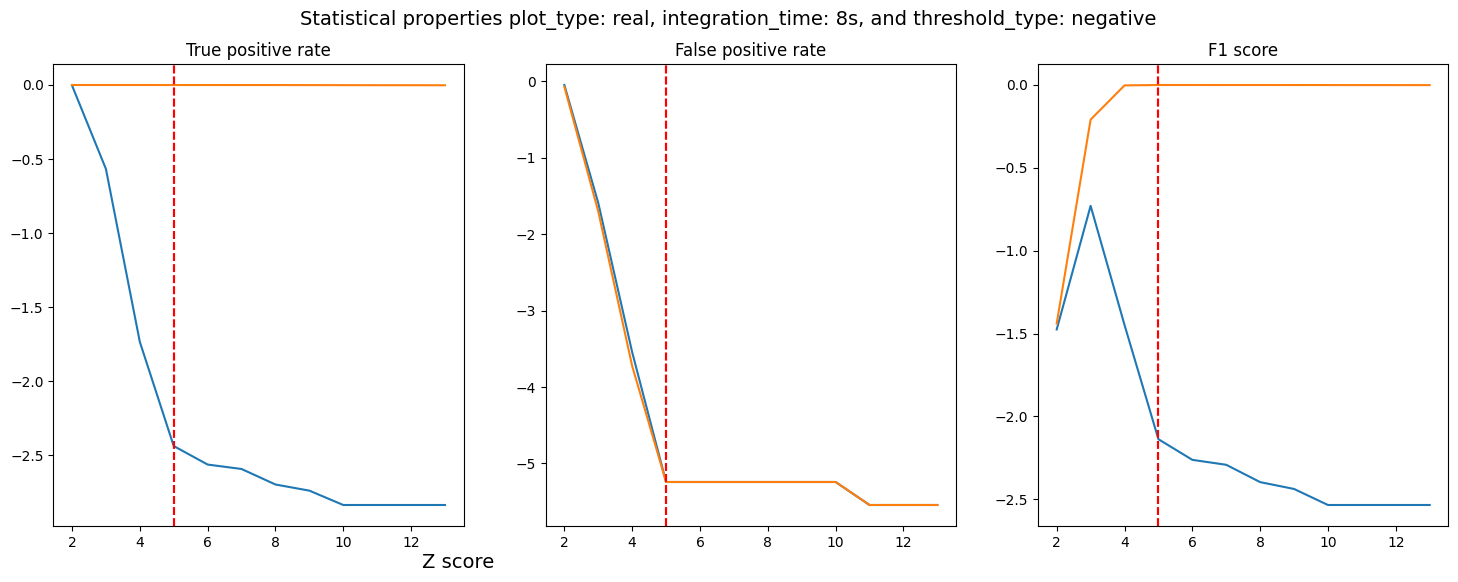

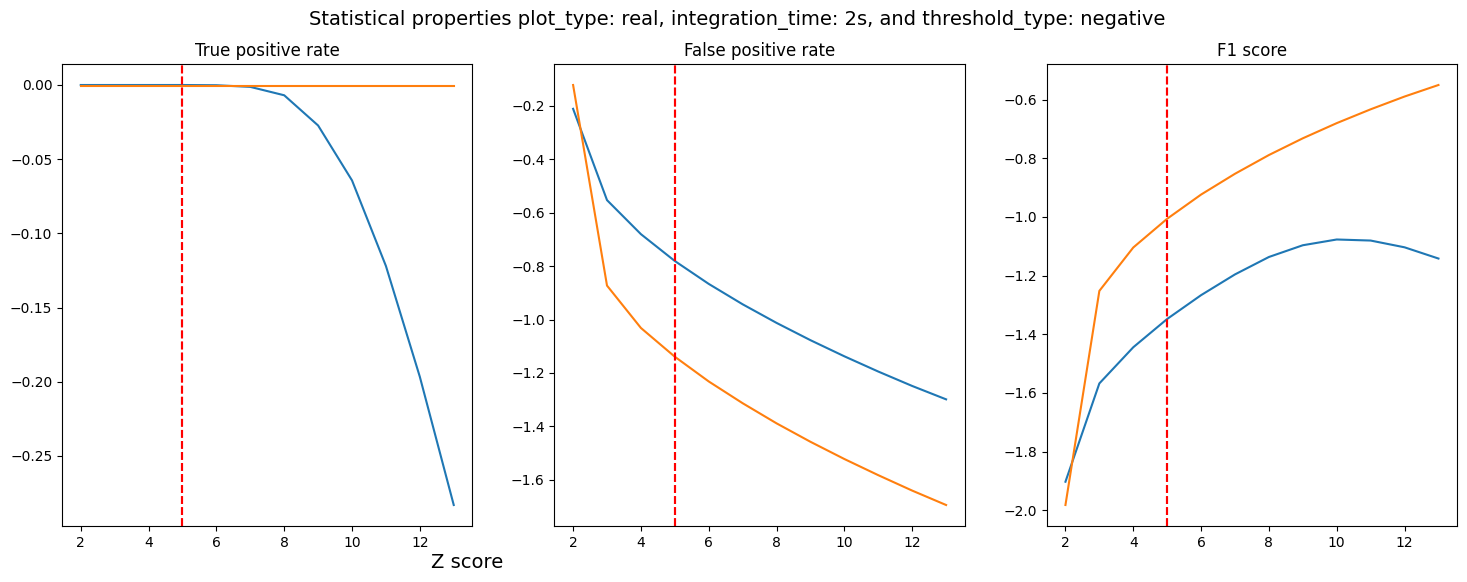

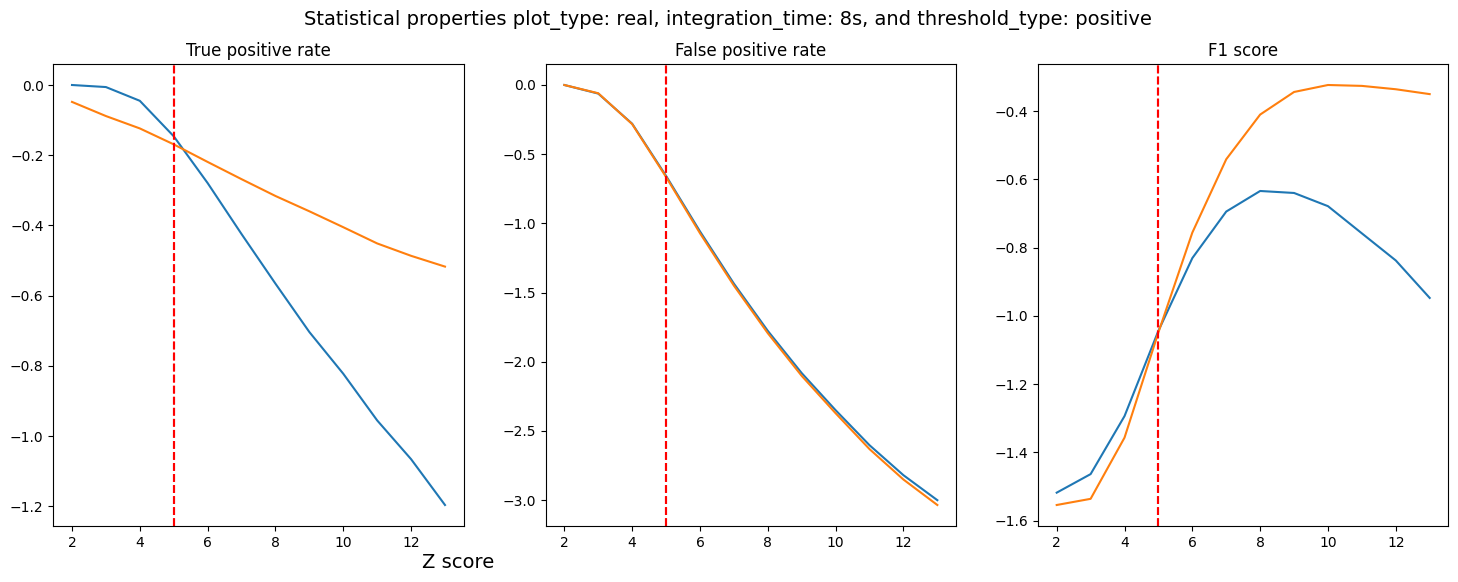

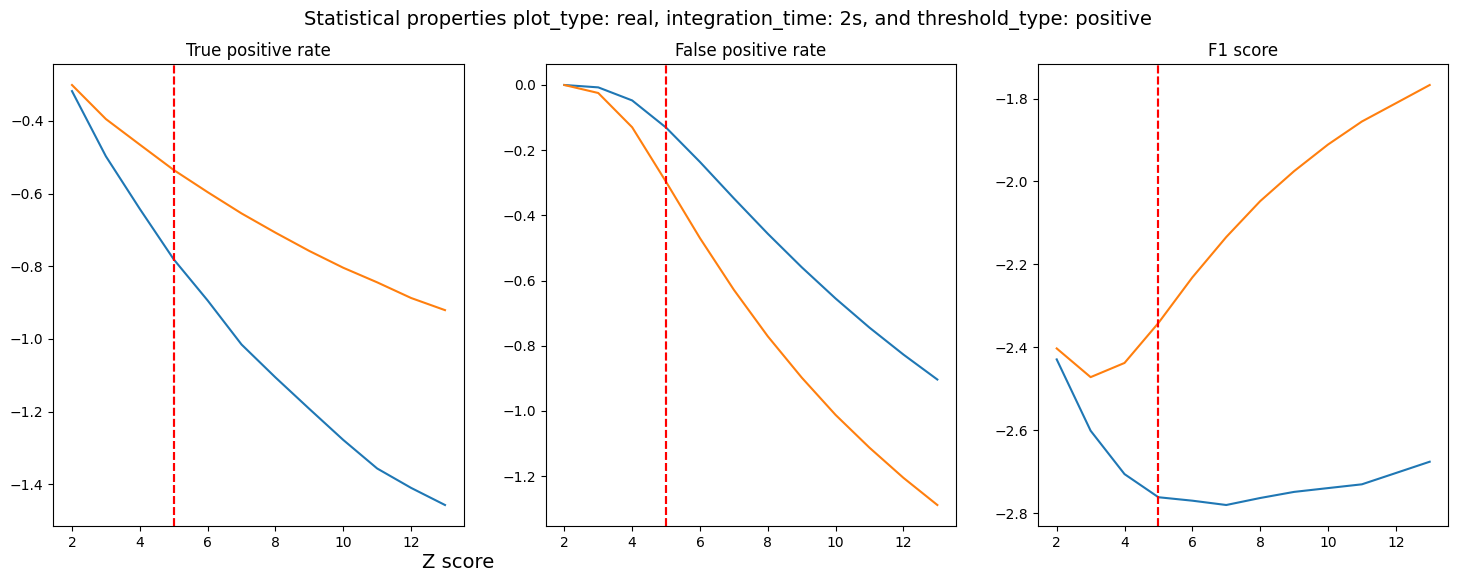

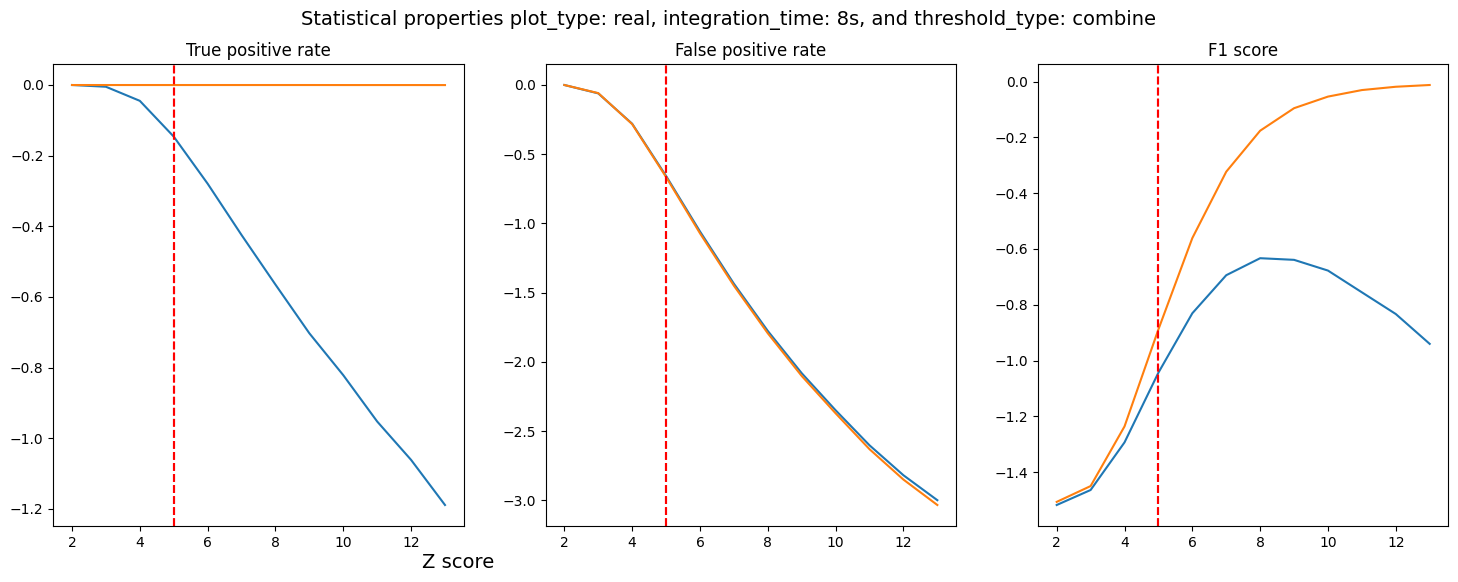

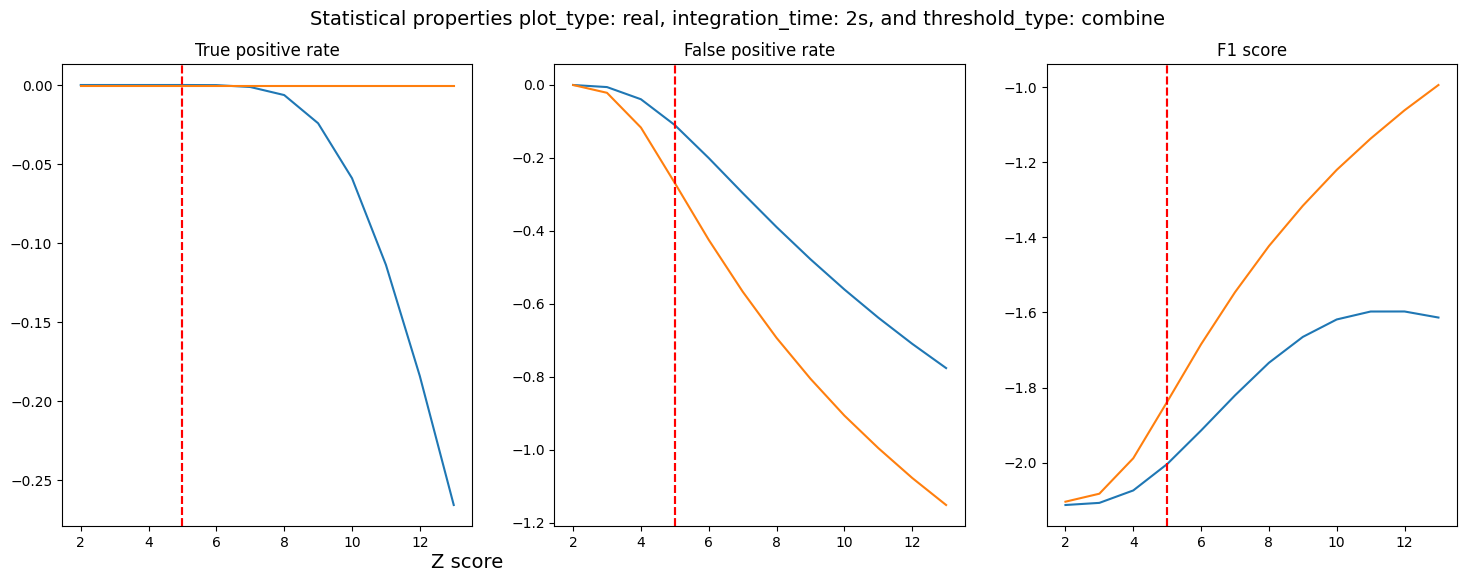

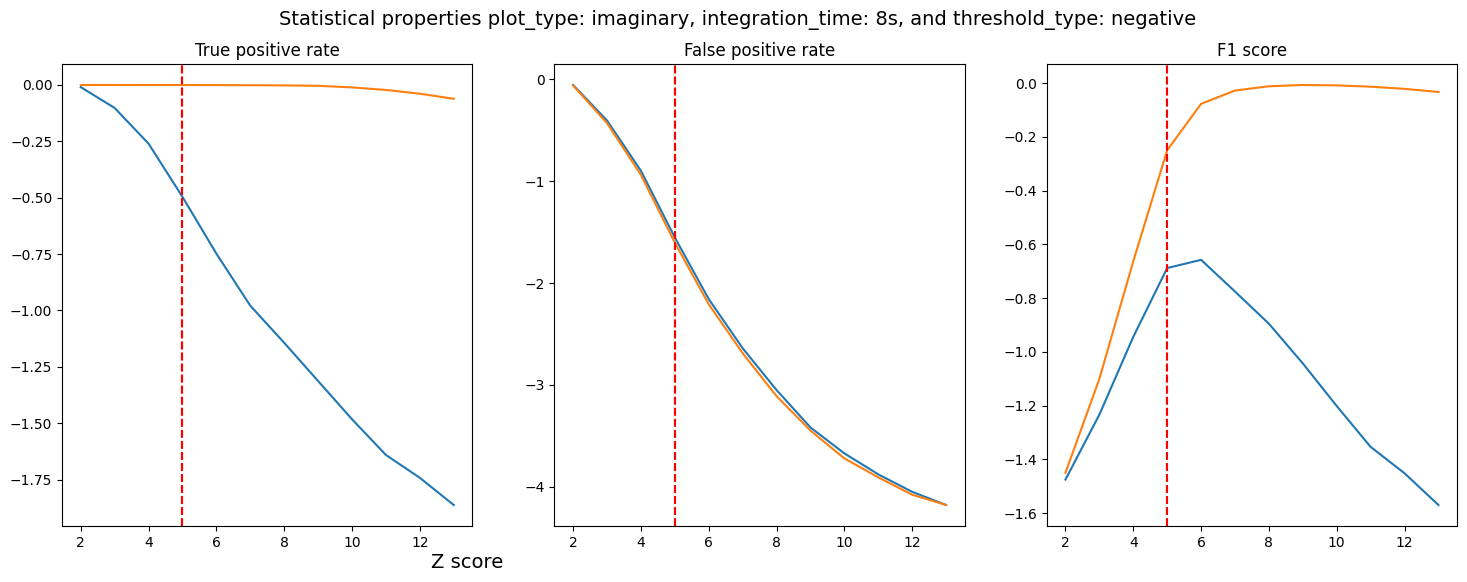

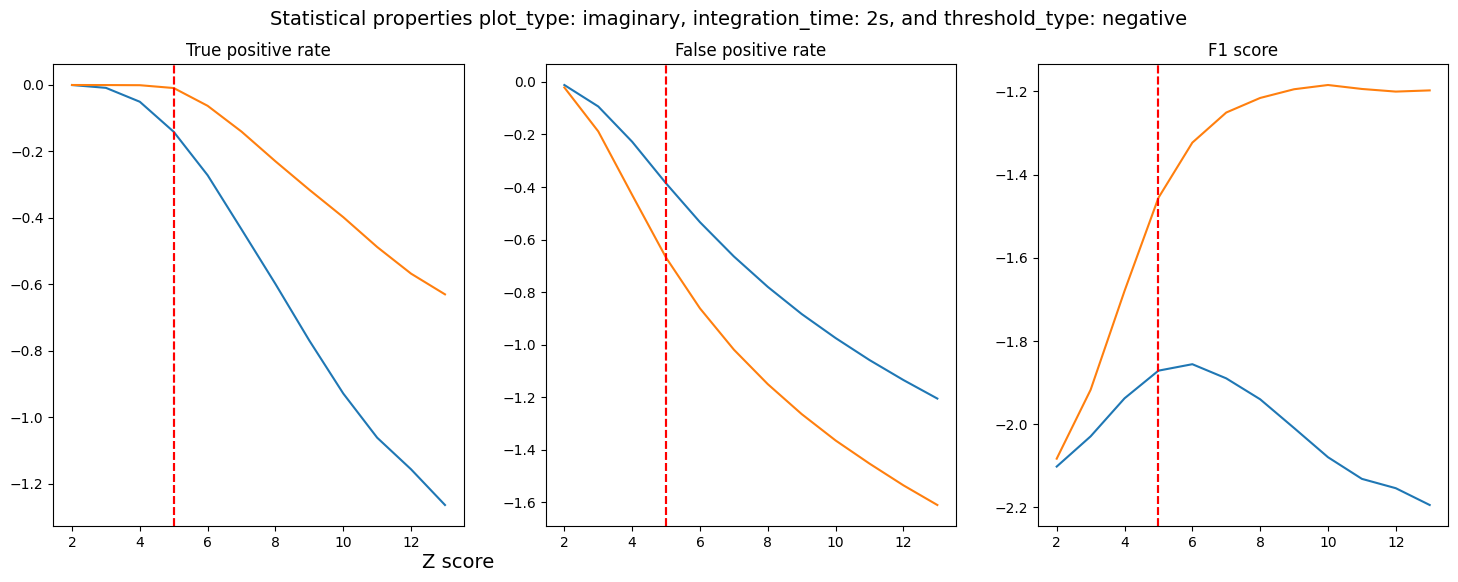

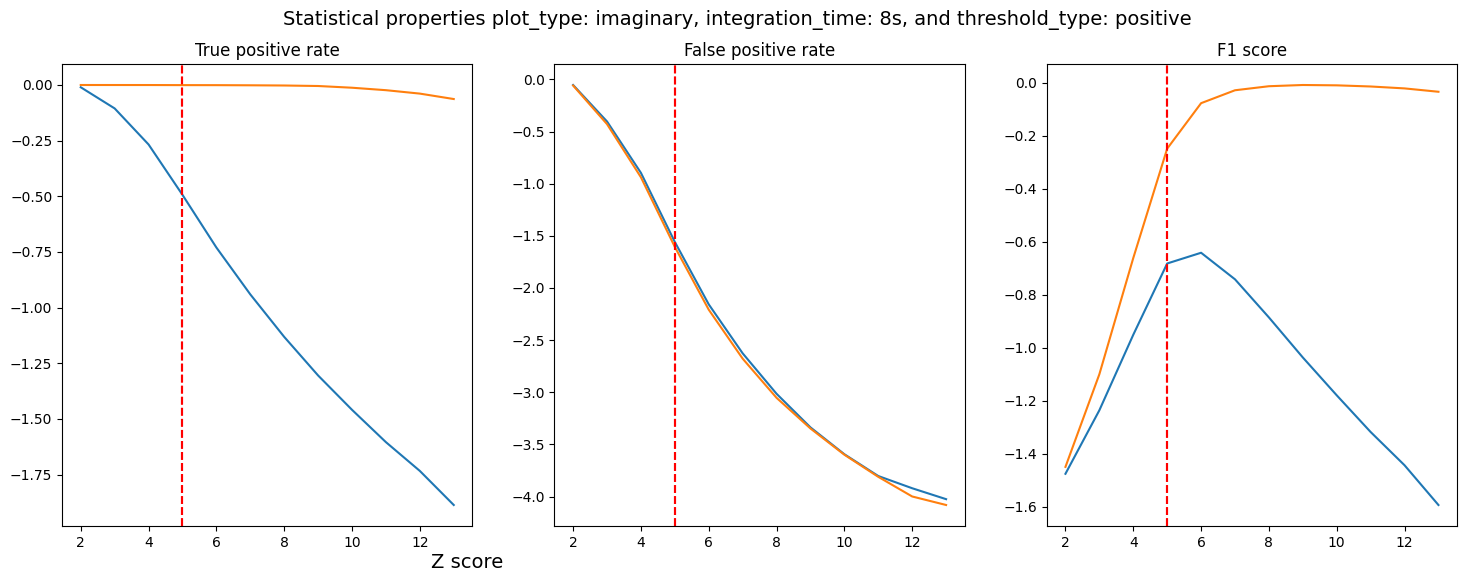

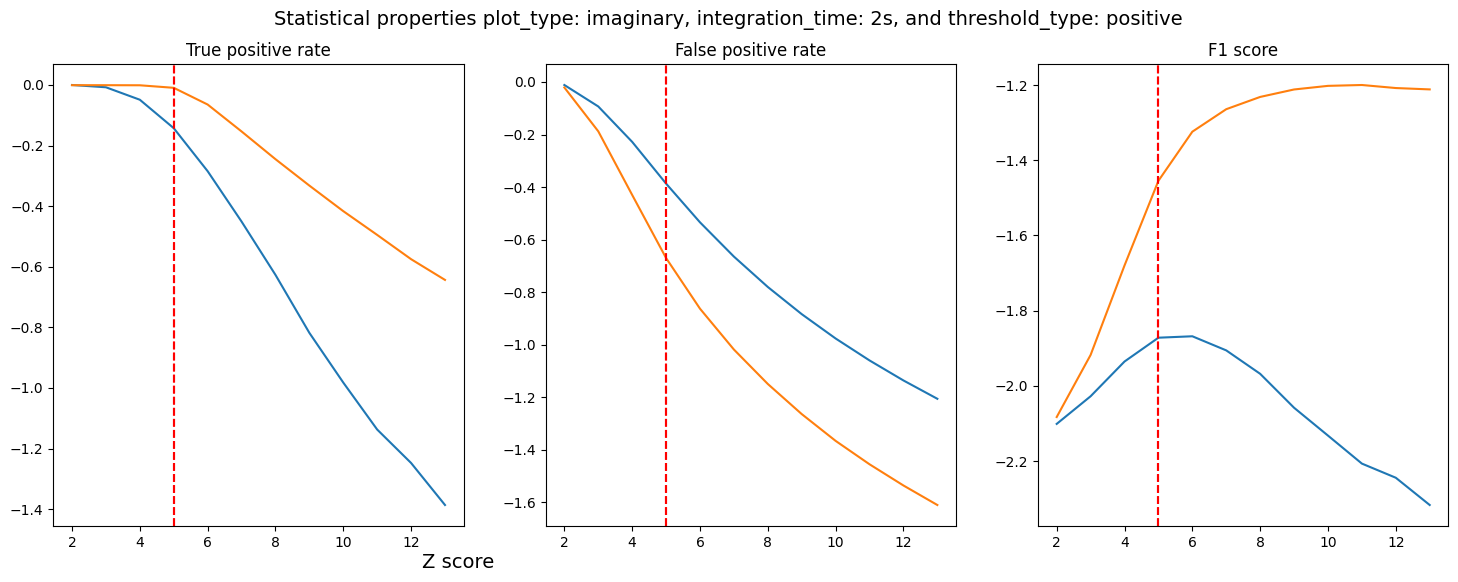

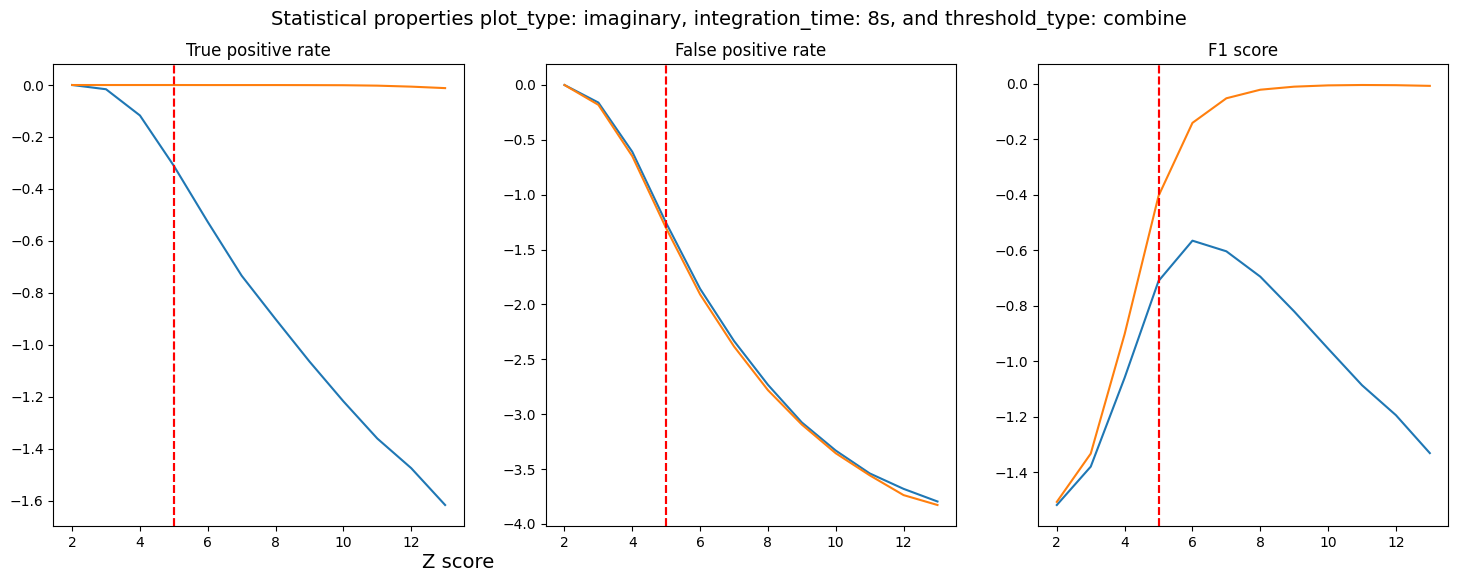

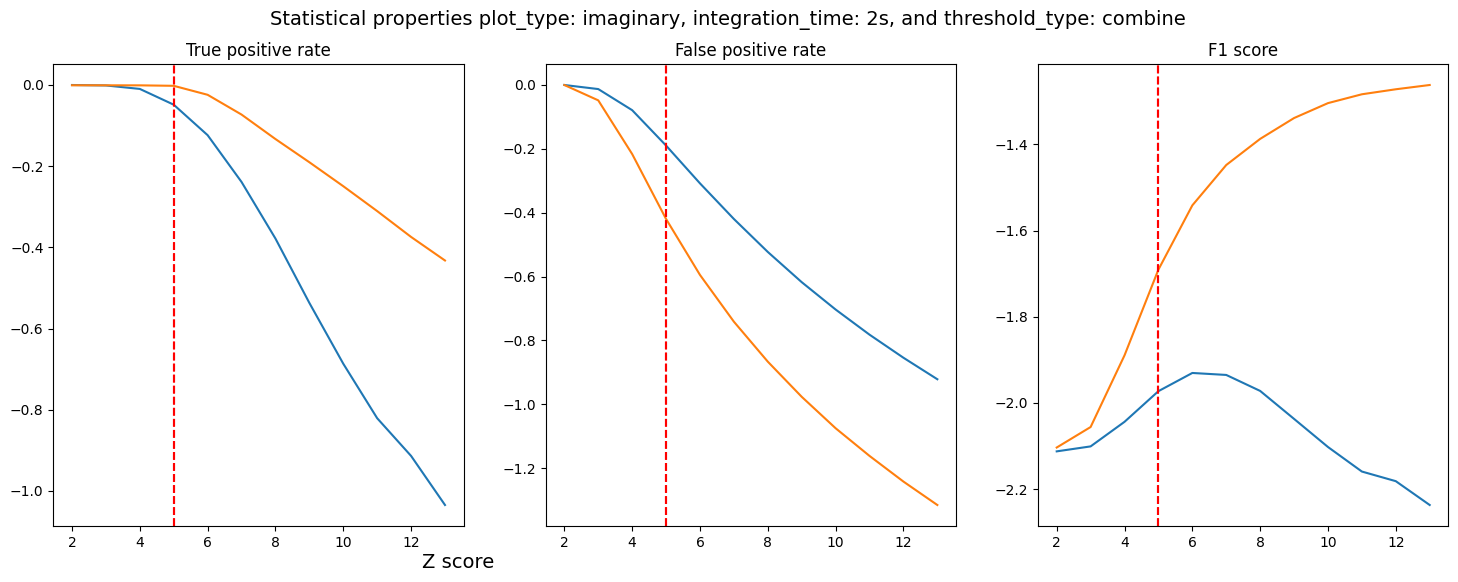

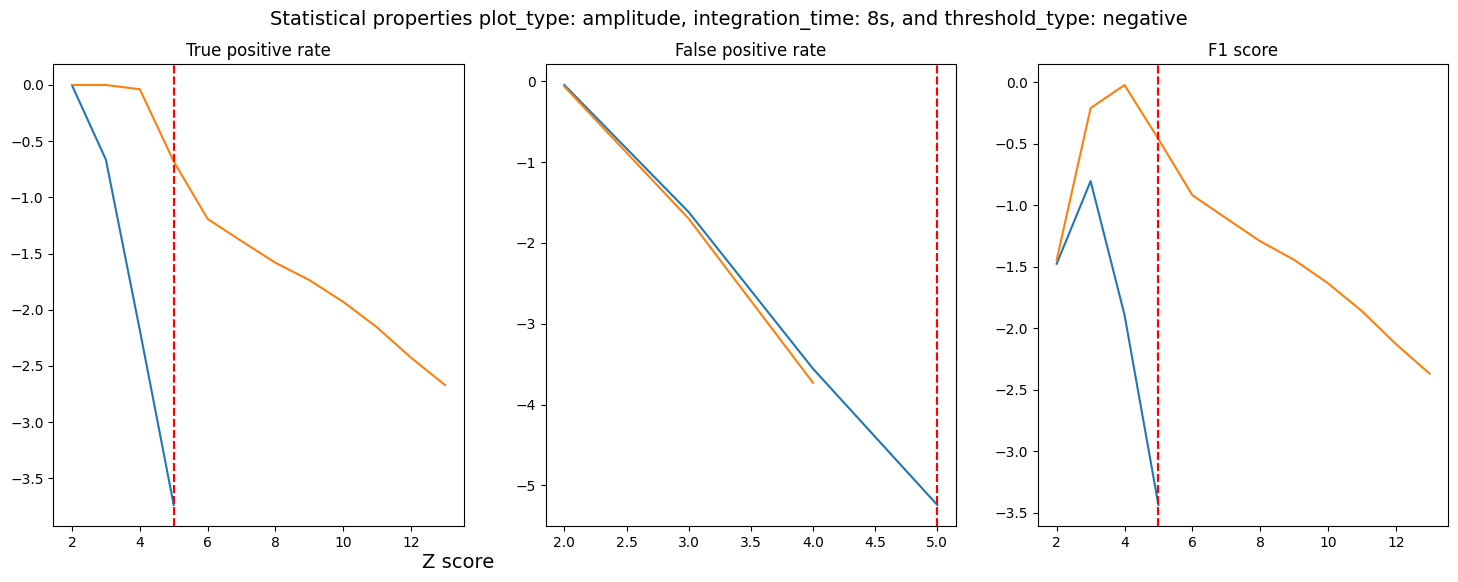

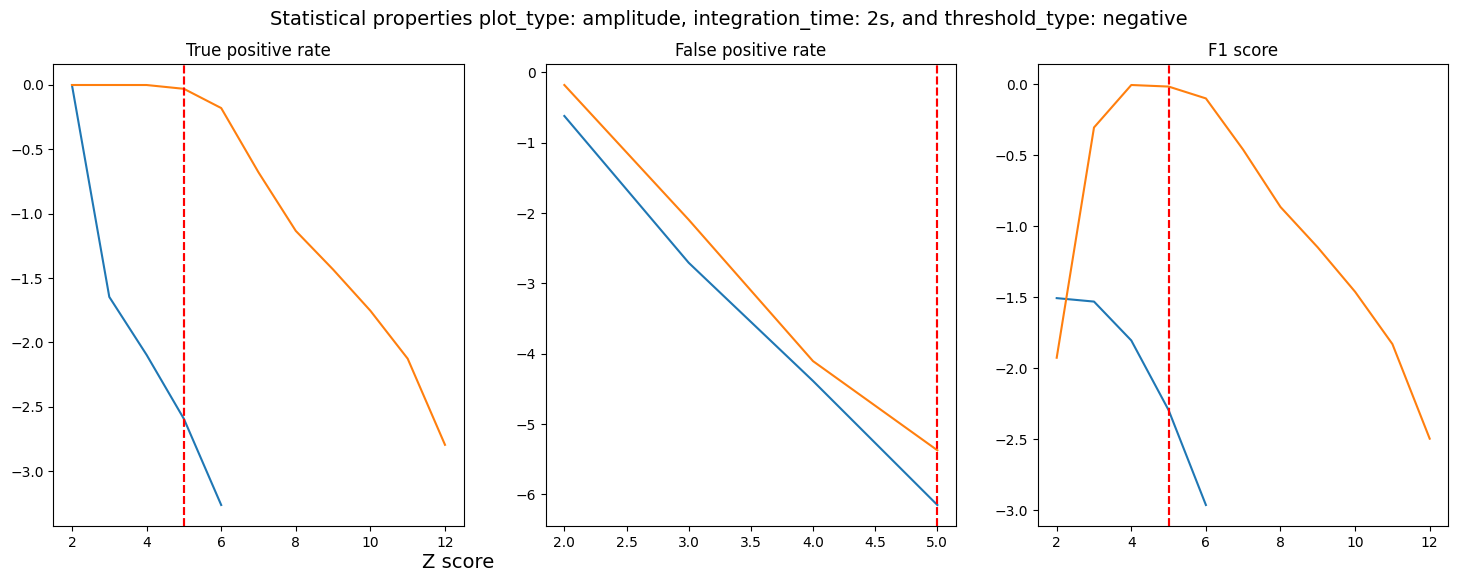

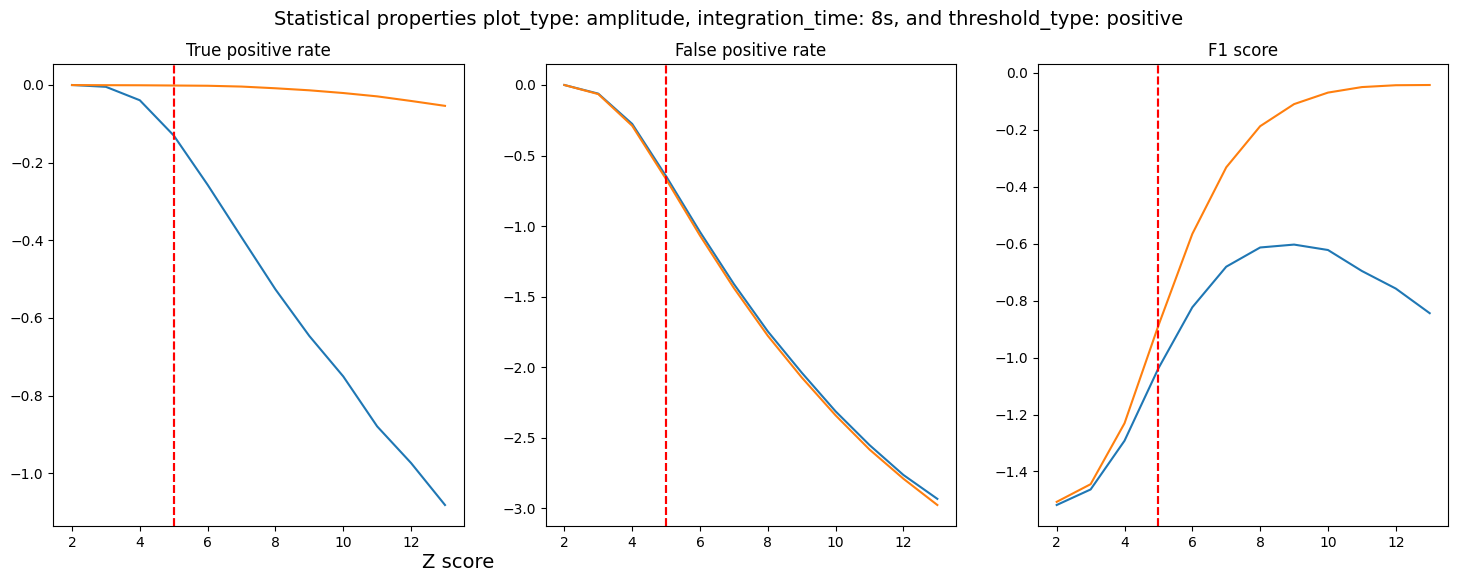

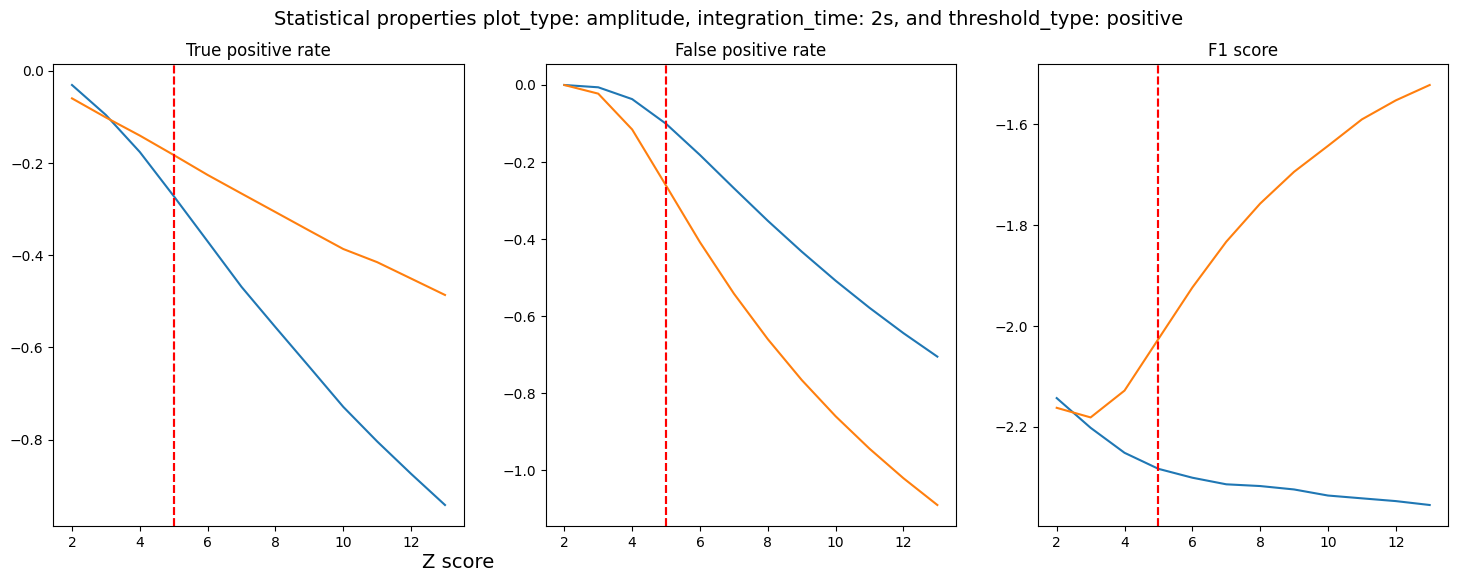

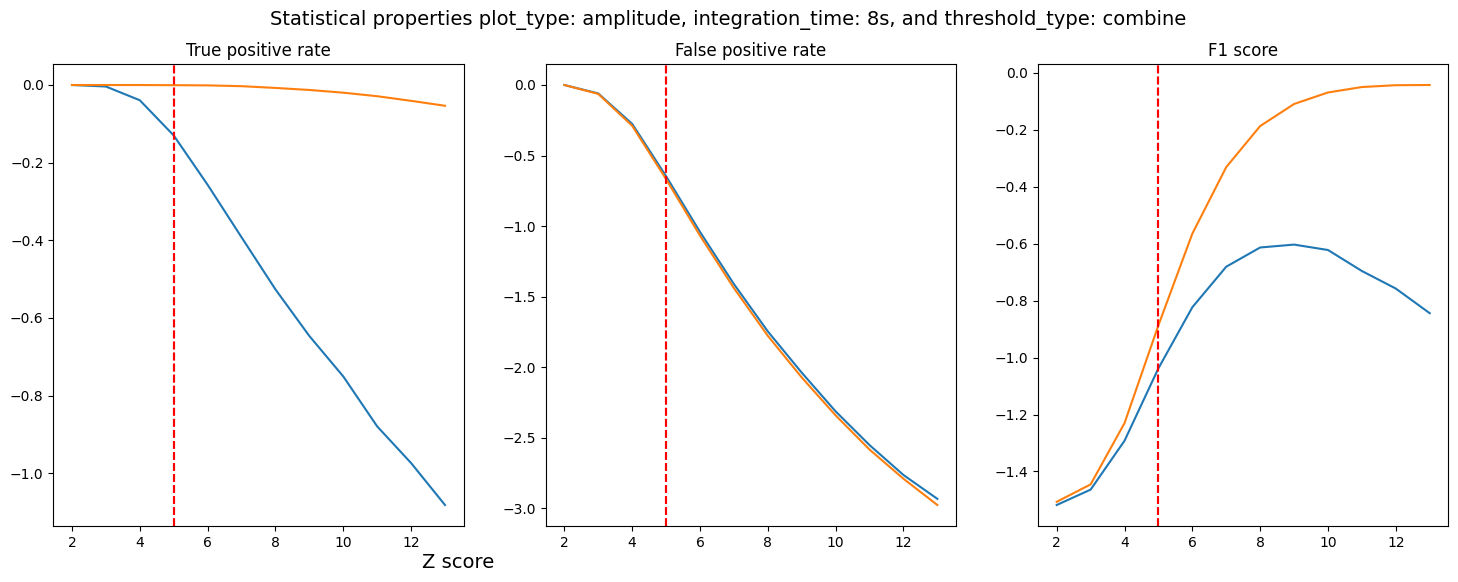

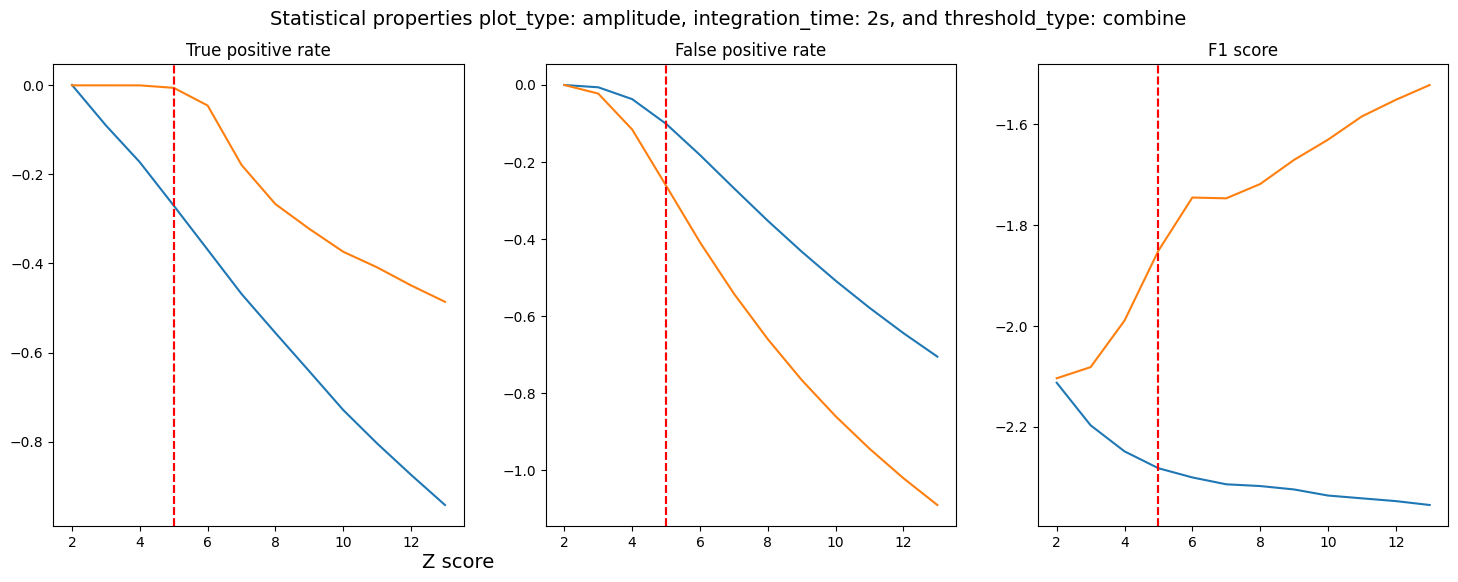

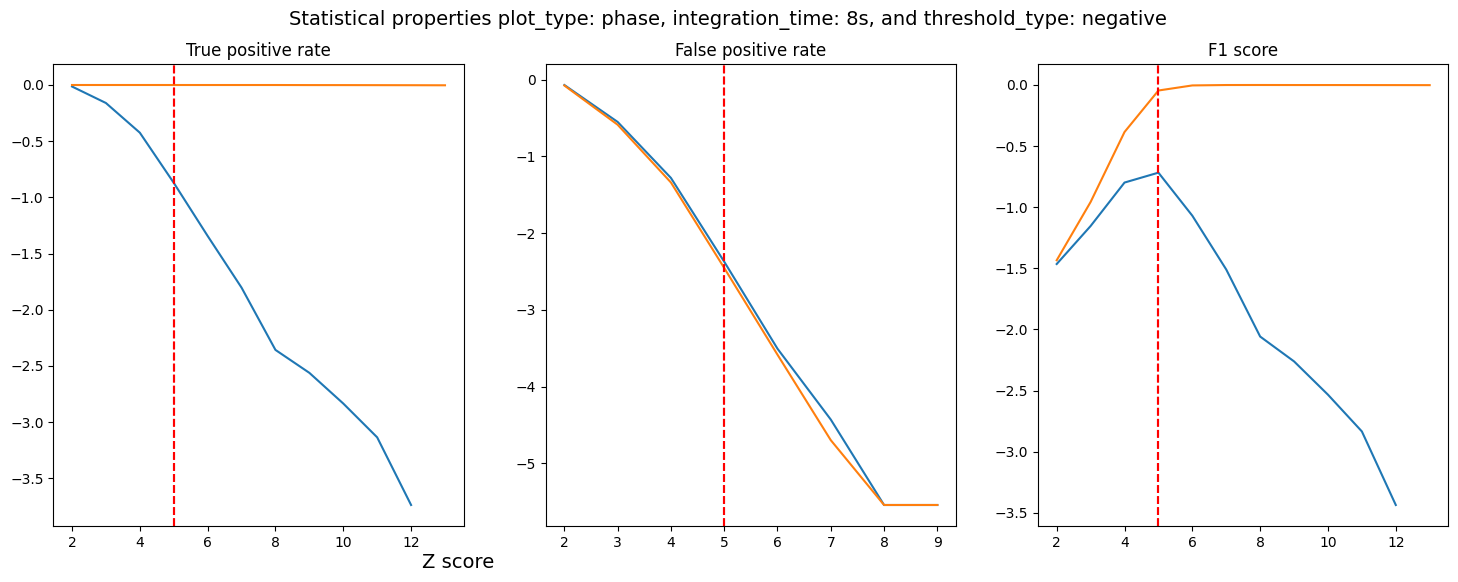

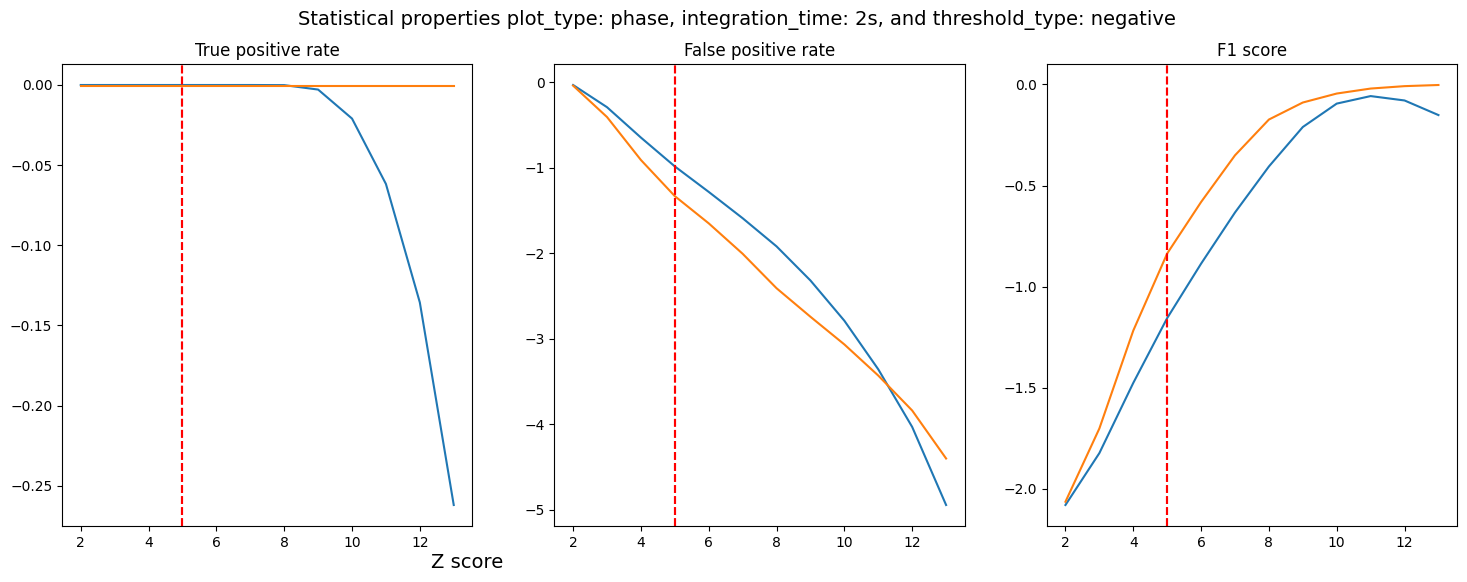

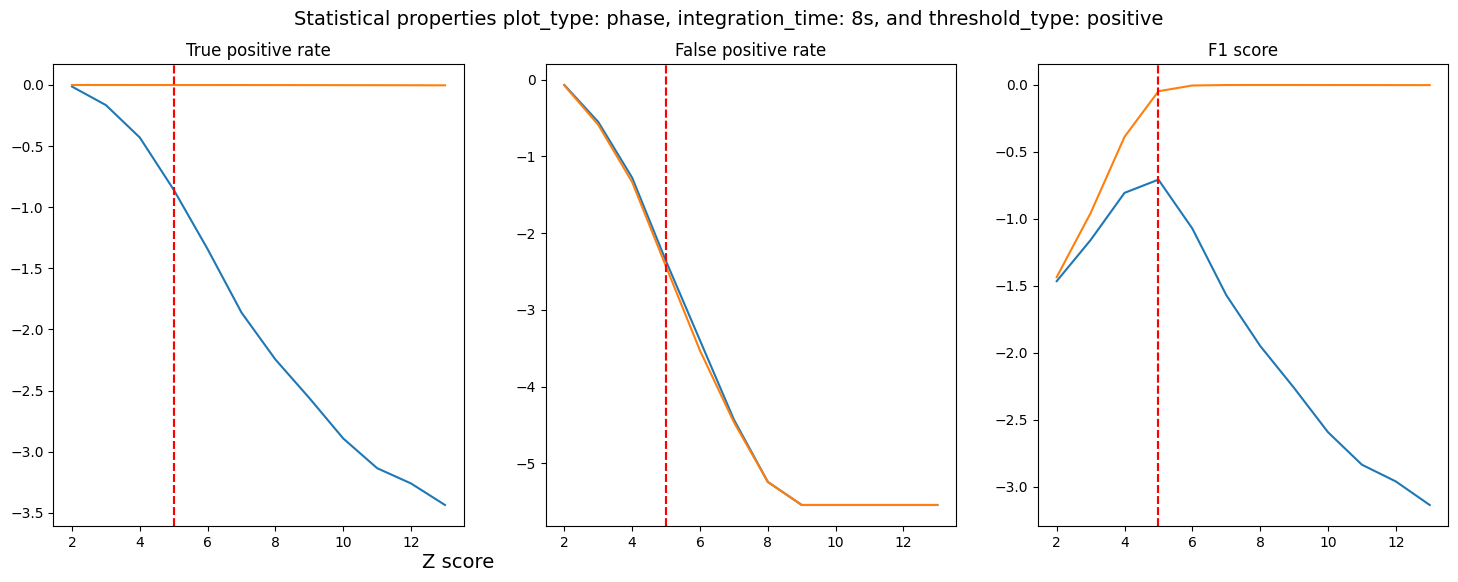

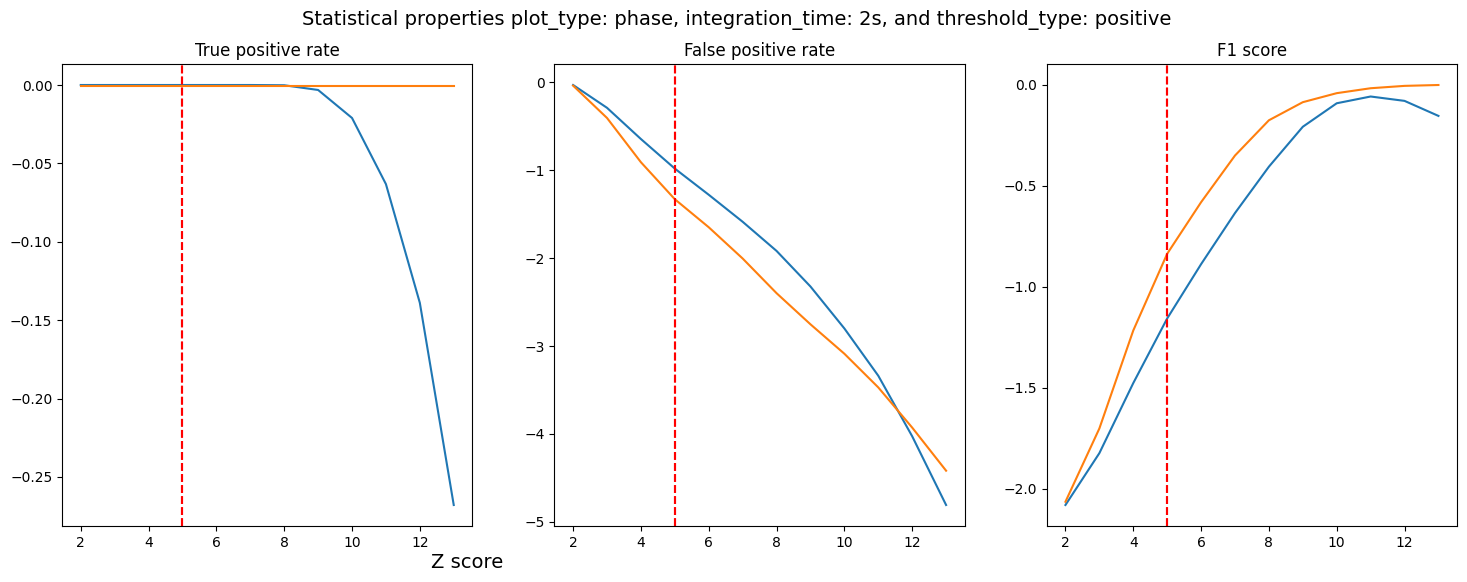

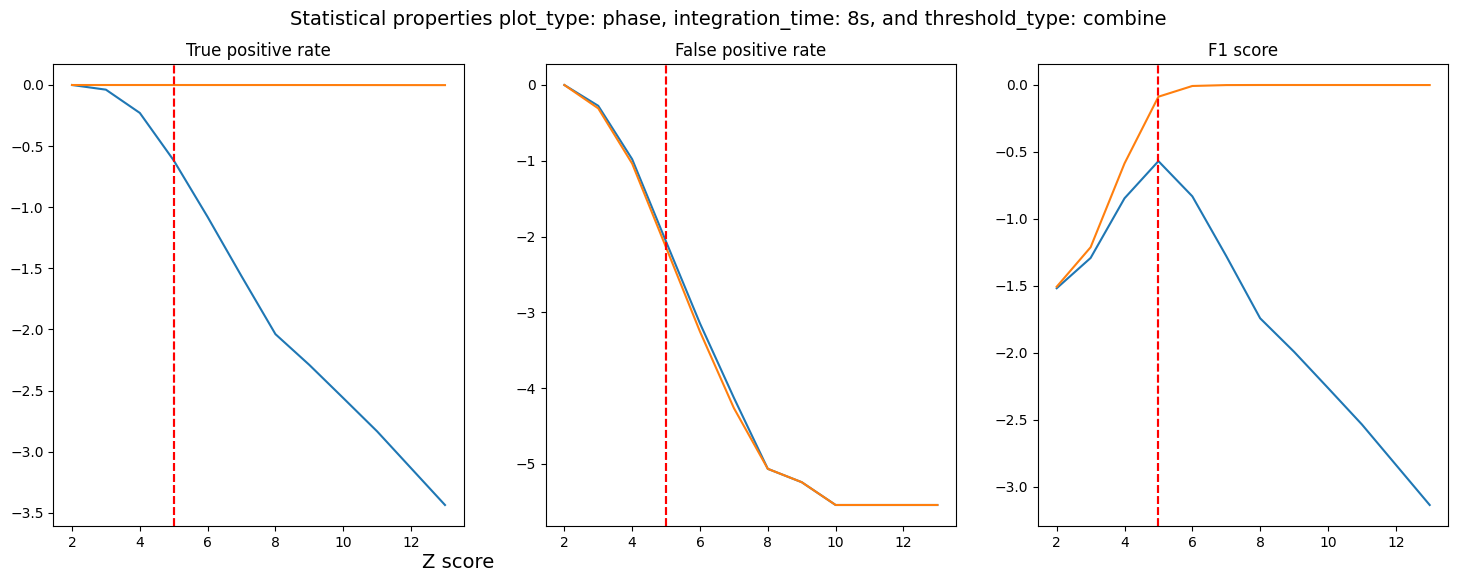

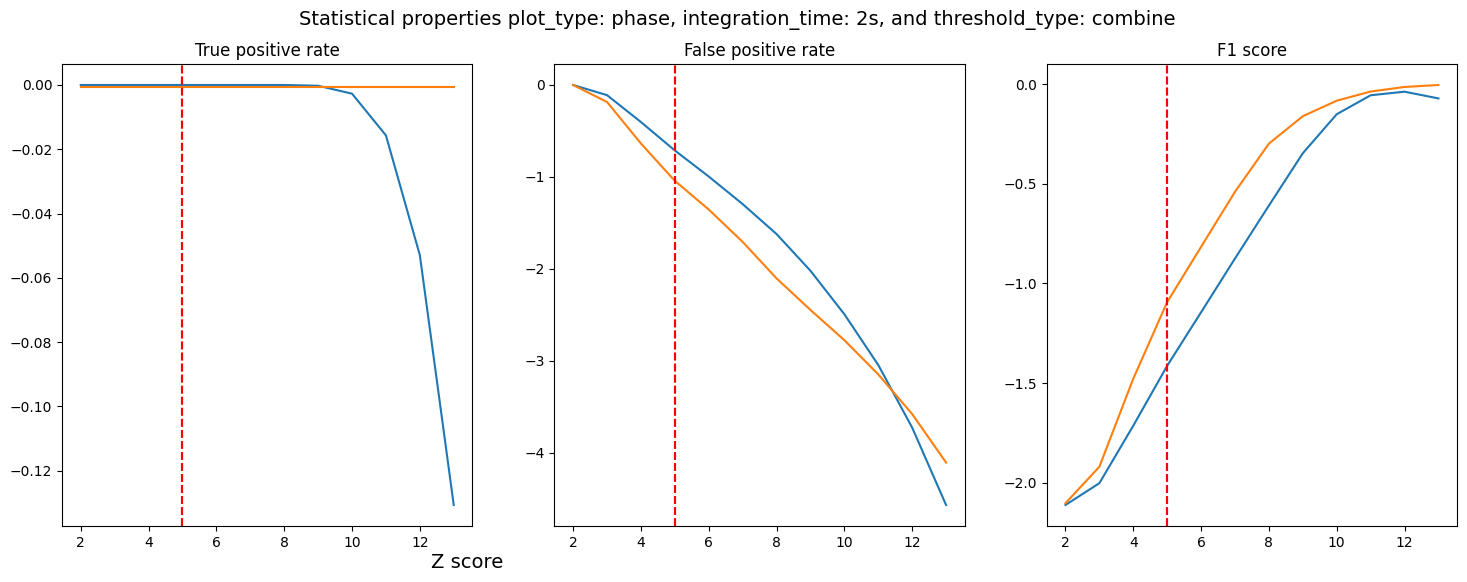

In [110]:
for ii in range(len(parts)):
    for jj in range(len(threshold_type)):
        for kk in range(len(integ)):

            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
            fig.suptitle('Statistical properties plot_type: %s, integration_time: %s, and threshold_type: %s' %(parts[ii], integ[kk], threshold_type[jj]), size=14, y=0.97)

            for ll in range(2): #len(sn)):

                sel_df = df_stats[(df_stats['integration'] == integ[kk]) & (df_stats['plot_type'] == parts[ii]) & (df_stats['sn'] == sn[ll]) & (df_stats['threshold_type'] == threshold_type[jj])][['z_score', 'tp', 'fp', 'f1', 'tp_rate', 'fp_rate']].reset_index(drop=True)

                z_alias['tp'] = z_alias.z_score.map(sel_df.set_index('z_score')['tp_rate'])
                z_alias['fp'] = z_alias.z_score.map(sel_df.set_index('z_score')['fp_rate'])
                z_alias['f1'] = z_alias.z_score.map(sel_df.set_index('z_score')['f1'])

                axes[0].plot(z_score, np.log10(z_alias['tp']), label=str(sn[ll]))
                axes[0].set_title('True positive rate', color='k', size=12)
                axes[0].axvline(x=5, color='red', linestyle='--')

                axes[1].plot(z_score, np.log10(z_alias['fp']), label=str(sn[ll]))
                axes[1].set_title('False positive rate', color='k', size=12)
                axes[1].axvline(x=5, color='red', linestyle='--')

                axes[2].plot(z_score, np.log10(z_alias['f1']), label=str(sn[ll]))
                axes[2].set_title('F1 score', color='k', size=12)
                axes[2].axvline(x=5, color='red', linestyle='--')
            
            fig.text(0.35, 0.04, "Z score", size=14, ha='center')

/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/User

Text(0.4, 0.07, 'z score')

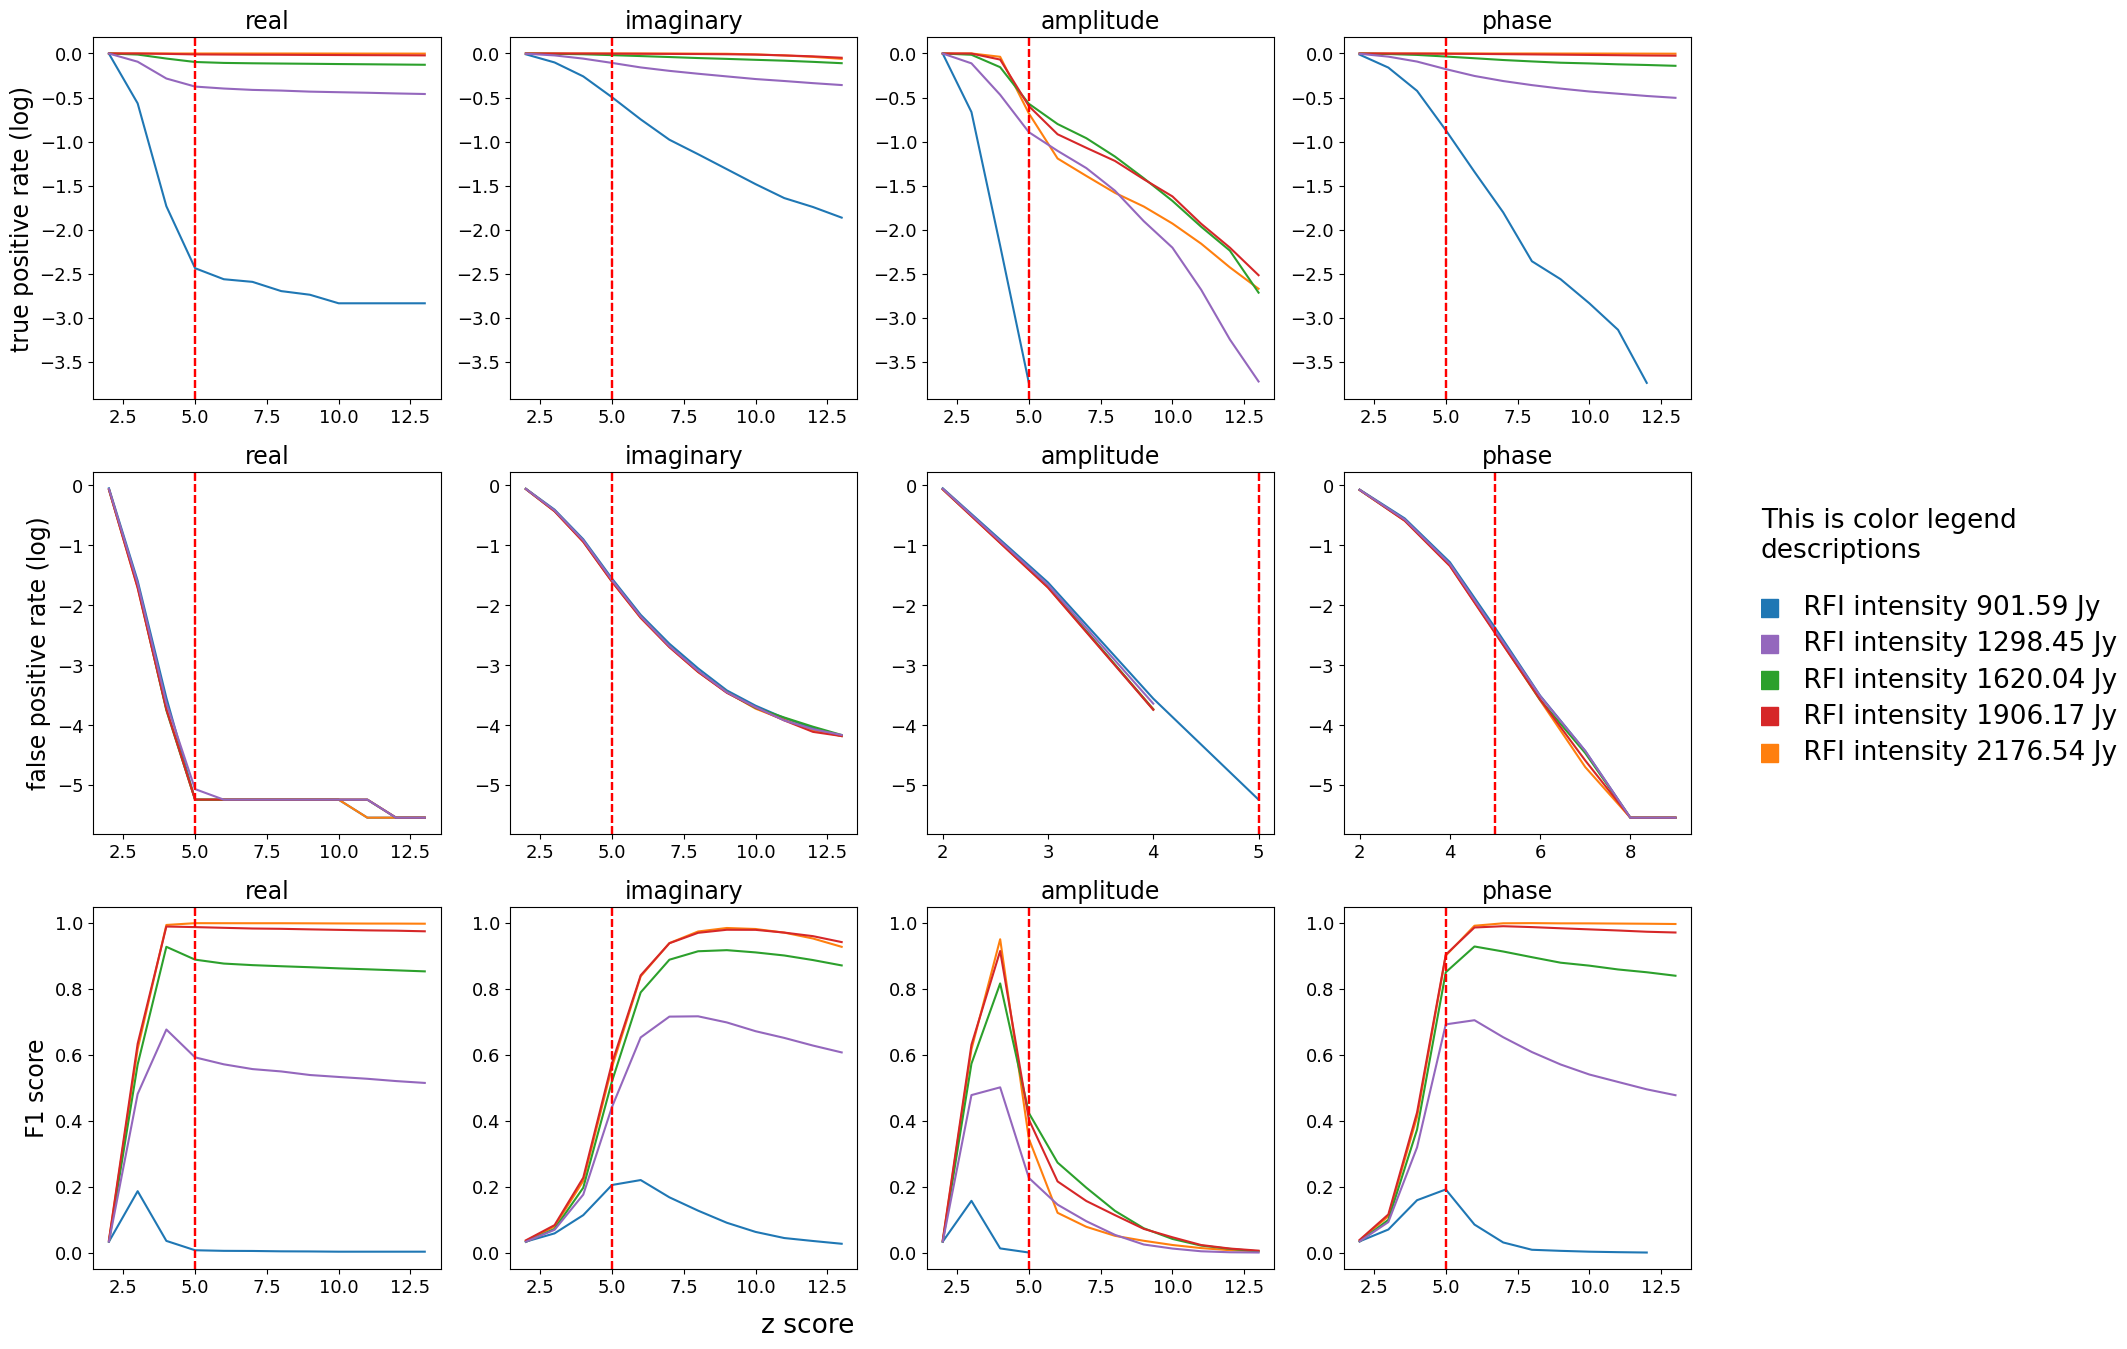

In [108]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(26, 16))
#fig.suptitle('Statistical properties simulated data with solution interval 8s and negative threshold', size=14, x=0.4, y=0.92)

for ii in range(len(parts)):
    for ll in range(len(sn)):

        sel_df = df_stats[(df_stats['integration'] == '8s') & (df_stats['plot_type'] == parts[ii]) & (df_stats['sn'] == sn[ll]) & (df_stats['threshold_type'] == 'negative')][['z_score', 'tp', 'fp', 'f1', 'tp_rate', 'fp_rate']].reset_index(drop=True)

        z_alias['tp'] = z_alias.z_score.map(sel_df.set_index('z_score')['tp_rate'])
        z_alias['fp'] = z_alias.z_score.map(sel_df.set_index('z_score')['fp_rate'])
        z_alias['f1'] = z_alias.z_score.map(sel_df.set_index('z_score')['f1'])

        axes[0, ii].plot(z_score, np.log10(z_alias['tp']), label=str(sn[ll]))
        axes[0, ii].set_title('%s' %(parts[ii]), color='k', size=17)
        axes[0, ii].axvline(x=5, color='red', linestyle='--')
        axes[0, ii].tick_params(axis='both', labelsize=13)
        axes[0, ii].sharey(axes[0, 0])
        axes[0, 0].set_ylabel('true positive rate (log)', size=17)

        axes[1, ii].plot(z_score, np.log10(z_alias['fp']), label=str(sn[ll]))
        axes[1, ii].set_title('%s' %(parts[ii]), color='k', size=17)
        axes[1, ii].axvline(x=5, color='red', linestyle='--')
        axes[1, ii].tick_params(axis='both', labelsize=13)
        axes[1, ii].sharey(axes[1, 0])
        axes[1, 0].set_ylabel('false positive rate (log)', size=17)

        axes[2, ii].plot(z_score, (z_alias['f1']), label=str(sn[ll]))
        axes[2, ii].set_title('%s' %(parts[ii]), color='k', size=17)
        axes[2, ii].axvline(x=5, color='red', linestyle='--')
        axes[2, ii].tick_params(axis='both', labelsize=13)
        axes[2, ii].sharey(axes[2, 0])
        axes[2, 0].set_ylabel('F1 score', size=17)


legend_ax = axes[1, 4]

axes[0, 4].axis("off")
axes[1, 4].axis("off")
axes[2, 4].axis("off")
#axes[3, 3].axis("off")

# Add a red rectangle
rect1 = Rectangle((0.0, 0.6), 0.05, 0.05, color='#1f77b4', transform=legend_ax.transAxes)
legend_ax.add_patch(rect1)
rect2 = Rectangle((0.0, 0.5), 0.05, 0.05, color='#9467bd', transform=legend_ax.transAxes)
legend_ax.add_patch(rect2)
rect3 = Rectangle((0.0, 0.4), 0.05, 0.05, color='#2ca02c', transform=legend_ax.transAxes)
legend_ax.add_patch(rect3)
rect4 = Rectangle((0.0, 0.3), 0.05, 0.05, color='#d62728', transform=legend_ax.transAxes)
legend_ax.add_patch(rect4)
rect5 = Rectangle((0.0, 0.2), 0.05, 0.05, color='#ff7f0e', transform=legend_ax.transAxes)
legend_ax.add_patch(rect5)

# Add text next to the rectangle
legend_ax.text(0.0, 0.825, 'This is color legend \ndescriptions', ha='left', va='center', fontsize=19, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.625, ' RFI intensity %s Jy' %(level[0]), ha='left', va='center', fontsize=19, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.525, ' RFI intensity %s Jy' %(level[1]), ha='left', va='center', fontsize=19, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.425, ' RFI intensity %s Jy' %(level[2]), ha='left', va='center', fontsize=19, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.325, ' RFI intensity %s Jy' %(level[3]), ha='left', va='center', fontsize=19, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.225, ' RFI intensity %s Jy' %(level[4]), ha='left', va='center', fontsize=19, transform=legend_ax.transAxes)

fig.text(0.4, 0.07, "z score", size=19, ha='center')
        

In [ ]:
# Create a figure for false positive vs true positive

from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 9))
#fig.suptitle('Statistical performance summary for model data', size=16, y=0.97)

for j in range(len(parts)):
    for i in range(len(level)):
        ax1 = axes[0,j]

        def custom_xlabels(x, pos):
            return f"-{x:.1f} "

        dplot = df_stats_mean[(df_stats_mean['level'] == level[i]) & (df_stats_mean['plot_type'] == plot_type[j]) & (df_stats_mean['integration'] == '8s') & (df_stats_mean['threshold_type'] == 'real')].reset_index(drop=True)

        # Plot lines for the left y-axis using the left_data DataFrame
        ax1.plot(dplot.z_score, np.log(dplot.tp_rate))

        ax1.set_title('%s' %(plot_type[j].capitalize()), size=14)
        ax1.set_ylabel('True positive', color='k', size=14)
        ax1.tick_params(axis='y', labelcolor='k', labelsize=12)
        ax1.axvline(x=5, color='red', linestyle='--')

        ax1.xaxis.set_major_formatter(FuncFormatter(custom_xlabels))

        # Create a twin y-axis sharing the same x-axis
        if i == 0:  # Create the secondary y-axis only once
            ax2 = ax1.twinx()

        # Plot lines for the right y-axis using the right_data DataFrame

        ax2.plot(dplot.z_score, np.log(dplot.fp_rate), linestyle='--')

        ax2.set_ylabel('False positive', color='k', size=14)
        ax2.tick_params(axis='y', labelcolor='k', labelsize=12)
        ax2.axvline(x=5, color='red', linestyle='--')
        ax2.xaxis.set_major_formatter(FuncFormatter(custom_xlabels))

        ax3 = axes[1,j]

        ax3.plot(dplot.z_score, (dplot.f1))
        ax3.set_ylabel('F1 score', color='k', size=14)
        ax3.tick_params(axis='y', labelcolor='k', labelsize=12)
        ax3.axvline(x=5, color='red', linestyle='--')
        ax3.xaxis.set_major_formatter(FuncFormatter(custom_xlabels))
        #ax3.text(89, np.mean(da['count']) + 0.5 , 'FM band limit', rotation=90, va='bottom', size=12)

        ax1.tick_params(axis='x', labelsize=14)
        ax2.tick_params(axis='x', labelsize=14)

legend_ax = axes[0,2]

legend_ax.axis('off')
# Add a red rectangle
rect1 = Rectangle((0.0, 0.6), 0.05, 0.05, color='#1f77b4', transform=legend_ax.transAxes)
legend_ax.add_patch(rect1)
rect2 = Rectangle((0.0, 0.5), 0.05, 0.05, color='#ff7f0e', transform=legend_ax.transAxes)
legend_ax.add_patch(rect2)
rect3 = Rectangle((0.0, 0.4), 0.05, 0.05, color='#2ca02c', transform=legend_ax.transAxes)
legend_ax.add_patch(rect3)
rect4 = Rectangle((0.0, 0.3), 0.05, 0.05, color='#d62728', transform=legend_ax.transAxes)
legend_ax.add_patch(rect4)
rect5 = Rectangle((0.0, 0.2), 0.05, 0.05, color='#9467bd', transform=legend_ax.transAxes)
legend_ax.add_patch(rect5)

# Add text next to the rectangle
legend_ax.text(0.0, 0.725, 'This is color legend descriptions', ha='left', va='center', fontsize=14, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.625, ' RFI intensity %s Jy' %(level[0]), ha='left', va='center', fontsize=14, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.525, ' RFI intensity %s Jy' %(level[1]), ha='left', va='center', fontsize=14, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.425, ' RFI intensity %s Jy' %(level[2]), ha='left', va='center', fontsize=14, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.325, ' RFI intensity %s Jy' %(level[3]), ha='left', va='center', fontsize=14, transform=legend_ax.transAxes)
legend_ax.text(0.1, 0.225, ' RFI intensity %s Jy' %(level[4]), ha='left', va='center', fontsize=14, transform=legend_ax.transAxes)

axes[1,2].axis('off')

# Show the plot
fig.text(0.35, 0.04, "Z score", size=14, ha='center')
plt.rcParams['xtick.labelsize'] = 14
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

---

### Importing 20% gamma data

In [111]:
outlier_path_20 = "/Volumes/eor_hdd_2/results_model_revision_251128/"
#outlier_path = "/Volumes/eor_hdd_2/results_model_revision_251128_5_5/"
added_rfi_path_20 = "/Users/eormacstudio/Documents/winsorized_statistics/winsorizing_model_visibility/higher_thermal_noise/same_level_noise/"

threshold_type_20 = ['negative', 'positive', 'combine']
polarizations_20 = ["XX"] #, "YY"]
parts_20 = ["real", "imaginary", "amplitude", "phase"]
sn_20 = ['sn1', 'sn5', 'sn3', 'sn4', 'sn2']
integ_20 = ['8s'] #, '2s']

level_20 = ['901.59', '1298.45', '1620.04', '1906.17', '2176.54']
df_rfi_level_20 = pd.DataFrame({'sn' : sn, 'level' : level})

time_convert_20 = np.repeat(np.arange(0,14), 4)
tile_list_20 = np.arange(0, 128, 1)
z_score_20 = np.arange(2, 14, 1)

cal_pol_alias_20 = pd.DataFrame({
    'pol': ['XX', 'XY', 'YX', 'YY']})
cal_pol_alias_20 = cal_pol_alias_20.reset_index()

vis_pol_alias_20 = pd.DataFrame({
    'pol': ['XX', 'YY', 'XY', 'YX']})
vis_pol_alias_20 = vis_pol_alias_20.reset_index()

z_alias_20 = pd.DataFrame({
    'z_score': z_score_20})
z_alias_20 = z_alias_20.reset_index(drop=True)

In [121]:
df_stats_20 = pd.DataFrame()

for i in range(len(parts_20)):
    for j in range(2): #len(sn)):
        for k in range(1): #len(polarizations)):
            for l in range(1): #len(integ_20)):
                print(parts_20[i], sn_20[j], polarizations_20[k], integ_20[l])

                # Added outliers

                df_rfi = pd.read_csv(added_rfi_path_20 + "%s/add_rfi_all_obs_location_multiple_rfi_fix_thermal_%s.txt" %(sn_20[j], sn_20[j]))
                df_rfi['pol_1'] = df_rfi['pol_1'].apply(lambda x: str(x).replace('[', '').replace(']', ''))
                df_rfi['pol_1'] = df_rfi['pol_1'].astype(int)
                df_rfi['polarization'] = df_rfi.pol_1.map(vis_pol_alias_20.set_index('index')['pol'])
                df_rfi = df_rfi[df_rfi['polarization'] == polarizations_20[k]].reset_index(drop=True)

                if integ_20[l] == '2s':
                    df_rfi['rfi_key'] = df_rfi.apply(lambda x: df_key(x['obs_id'], x['timeblock'], x['channel']),  axis=1)
                    df_rfi = df_rfi.drop_duplicates(subset=['rfi_key'], keep='last').reset_index(drop=True)
                    df_rfi['alias'] = 1
                elif integ_20[l] == '8s':
                    df_rfi['timeblock_alias'] = df_rfi['timeblock'].apply(lambda x: time_convert[x])
                    df_rfi['rfi_key'] = df_rfi.apply(lambda x: df_key(x['obs_id'], x['timeblock_alias'], x['channel']),  axis=1)
                    df_rfi = df_rfi.drop_duplicates(subset=['rfi_key'], keep='last').reset_index(drop=True)
                    df_rfi['alias'] = 1
                
                #print(df_rfi)

                df_detected_outliers = pd.DataFrame()
                for o in range(len(gn)):
                    print(outlier_path_20+"%s/%s/%s/win_z_scores_data_day_1_grid_%s_integration_%s_%s_part_1_gp_%s.h5" %(sn_20[j], integ_20[l], parts_20[i], gn[o], integ_20[l][0], parts_20[i], gn[o]))
                    
                    aa = load_outliers_from_h5(outlier_path_20+"%s/%s/%s/win_z_scores_data_day_1_grid_%s_integration_%s_%s_part_1_gp_%s.h5" %(sn_20[j], integ_20[l], parts_20[i], gn[o], integ_20[l][0], parts_20[i], gn[o]), polarizations_20)
                    df_detected_outliers = pd.concat([df_detected_outliers, aa]).reset_index(drop = True)

                for m in range(len(z_score_20)):
                    print('running for z-score: ', z_score_20[m])
                    for n in range(len(threshold_type_20)):
                        print(threshold_type_20[n])
                        
                        # Reduce df_detected_outliers
                        if threshold_type_20[n] == 'positive':
                            ss = df_detected_outliers[(df_detected_outliers[polarizations_20[k]] > z_score_20[m])].reset_index(drop=True)
                        elif threshold_type_20[n] == 'negative':
                            ss = df_detected_outliers[(df_detected_outliers[polarizations_20[k]] < -z_score_20[m])].reset_index(drop=True)
                        elif threshold_type_20[n] == 'combine':
                            ss = df_detected_outliers[np.abs(df_detected_outliers[polarizations_20[k]]) > z_score_20[m]].reset_index(drop=True)

                        #print('ss: ', ss)
                        if len(ss) != 0:

                            ss['rfi_key'] = ss.apply(lambda x: df_key(x['obs_id'], x['timeblock'], x['frequency']),  axis=1)

                            ss = ss.drop_duplicates(subset=['rfi_key'], keep='last').reset_index(drop=True)
                            ss['alias'] = 1

                            if integ_20[l] == '2s':
                                # Create default dataframe
                                # Step 1: Create the data

                                data_A = np.arange(0, 56)
                                data_B = np.arange(0, 768)

                                # Step 2: Generate the Cartesian product

                                column_A = np.repeat(obs_list, len(data_A) * len(data_B))
                                column_B = np.tile(np.repeat(data_A, len(data_B)), len(obs_list))
                                column_C = np.tile(data_B, len(obs_list) * len(data_A))

                                # Step 3: Construct the DataFrame

                                df = pd.DataFrame({
                                    'obs_id': column_A,
                                    'timeblocks': column_B,
                                    'freqs': column_C
                                })

                            elif integ_20[l] == '8s':
                                # Create default dataframe
                                # Step 1: Create the data

                                data_A = np.arange(0, 14)
                                data_B = np.arange(0, 768)

                                # Step 2: Generate the Cartesian product

                                column_A = np.repeat(obs_list, len(data_A) * len(data_B))
                                column_B = np.tile(np.repeat(data_A, len(data_B)), len(obs_list))
                                column_C = np.tile(data_B, len(obs_list) * len(data_A))

                                # Step 3: Construct the DataFrame

                                df = pd.DataFrame({
                                    'obs_id': column_A,
                                    'timeblocks': column_B,
                                    'freqs': column_C
                                })

                            df['rfi_key'] = df.apply(lambda x: df_key(x['obs_id'], x['timeblocks'], x['freqs']),  axis=1)
                            df['added_rfi'] = df.rfi_key.map(df_rfi.set_index('rfi_key')['alias'])
                            df['detected_rfi'] = df.rfi_key.map(ss.set_index('rfi_key')['alias'])
                            df = df.fillna(0)

                            #print(df)

                            # Calculate all metrics
                            cm = confusion_matrix(df['added_rfi'], df['detected_rfi'])

                            accuracy = accuracy_score(df['added_rfi'], df['detected_rfi'])
                            precision = precision_score(df['added_rfi'], df['detected_rfi'])
                            recall = recall_score(df['added_rfi'], df['detected_rfi'])
                            f1 = f1_score(df['added_rfi'], df['detected_rfi'])

                            TN = cm[0,0]
                            FP = cm[0,1]
                            FN = cm[1,0]
                            TP = cm[1,1]

                            fsdata = {'plot_type': [parts_20[i]],
                                    'sn': [sn_20[j]],
                                    'polarization': [polarizations_20[k]],
                                    'total_rfi': [len(df_rfi)],
                                    'integration': [integ_20[l]],
                                    'z_score': [z_score_20[m]],
                                    'threshold_type': [threshold_type_20[n]],
                                    'accuracy': [accuracy],
                                    'precision': [precision],
                                    'recall': [recall],
                                    'f1': [f1],
                                    'tp': [TP],
                                    'fp': [FP],
                                    'tn': [TN],
                                    'fn': [FN]}
                            
                            # Create the DataFrame
                            bb = pd.DataFrame(fsdata)
                            df_stats_20 = pd.concat([df_stats_20, bb]).reset_index(drop = True)
                            
                        else:
                            continue

df_stats_20['tp_rate'] = df_stats_20['tp']/df_stats_20['total_rfi']
df_stats_20['fp_rate'] = df_stats_20['fp']/(df_stats_20['fp'] + df_stats_20['tn'])

real sn1 XX 8s
/Volumes/eor_hdd_2/results_model_revision_251128/sn1/8s/real/win_z_scores_data_day_1_grid_0_integration_8_real_part_1_gp_0.h5
Outliers:  (224, 128, 768, 4)
/Volumes/eor_hdd_2/results_model_revision_251128/sn1/8s/real/win_z_scores_data_day_1_grid_1_integration_8_real_part_1_gp_1.h5
Outliers:  (112, 128, 768, 4)
/Volumes/eor_hdd_2/results_model_revision_251128/sn1/8s/real/win_z_scores_data_day_1_grid_2_integration_8_real_part_1_gp_2.h5
Outliers:  (126, 128, 768, 4)
running for z-score:  2
negative
positive
combine
running for z-score:  3
negative
positive
combine
running for z-score:  4
negative
positive
combine
running for z-score:  5
negative
positive
combine
running for z-score:  6
negative
positive
combine
running for z-score:  7
negative
positive
combine
running for z-score:  8
negative
positive
combine
running for z-score:  9
negative
positive
combine
running for z-score:  10
negative
positive
combine
running for z-score:  11
negative
positive
combine
running for z-s

In [123]:
df_stats

,plot_type,sn,polarization,total_rfi,integration,z_score,threshold_type,accuracy,precision,recall,f1,tp,fp,tn,fn,tp_rate,fp_rate
0,real,sn1,XX,5467,8s,2,negative,0.115928,0.017024,0.993598,0.033474,5432,313648,35701,35,0.993598,0.897807
1,real,sn1,XX,5467,8s,2,positive,0.015639,0.015412,1.000000,0.030355,5467,349267,82,0,1.000000,0.999765
2,real,sn1,XX,5467,8s,2,combine,0.015433,0.015408,1.000000,0.030349,5467,349340,9,0,1.000000,0.999974
3,real,sn1,XX,5467,8s,3,negative,0.963505,0.142010,0.271447,0.186467,1484,8966,340383,3983,0.271447,0.025665
4,real,sn1,XX,5467,8s,3,positive,0.146614,0.017506,0.986647,0.034402,5394,302722,46627,73,0.986647,0.866532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,phase,sn2,XX,5337,2s,12,positive,0.998905,0.966922,0.733933,0.834470,3917,134,1413793,1420,0.733933,0.000095
1396,phase,sn2,XX,5337,2s,12,combine,0.999407,0.946386,0.893011,0.918924,4766,270,1413657,571,0.893011,0.000191
1397,phase,sn2,XX,5337,2s,13,negative,0.998372,0.994121,0.570358,0.724848,3044,18,1413909,2293,0.570358,0.000013
1398,phase,sn2,XX,5337,2s,13,positive,0.998323,0.991686,0.558741,0.714765,2982,25,1413902,2355,0.558741,0.000018


In [125]:
df_stats_20[df_stats_20['plot_type'] == 'real']

,plot_type,sn,polarization,total_rfi,integration,z_score,threshold_type,accuracy,precision,recall,f1,tp,fp,tn,fn,tp_rate,fp_rate
0,real,sn1,XX,5467,8s,2,negative,0.135780,0.017387,0.992318,0.034174,5425,306597,42752,42,0.992318,0.877624
1,real,sn1,XX,5467,8s,2,positive,0.015766,0.015414,1.000000,0.030359,5467,349222,127,0,1.000000,0.999636
2,real,sn1,XX,5467,8s,2,combine,0.015453,0.015409,1.000000,0.030350,5467,349333,16,0,1.000000,0.999954
3,real,sn1,XX,5467,8s,3,negative,0.974412,0.187435,0.198098,0.192619,1083,4695,344654,4384,0.198098,0.013439
4,real,sn1,XX,5467,8s,3,positive,0.193238,0.018361,0.978965,0.036046,5352,286137,63212,115,0.978965,0.819058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,real,sn5,XX,5613,8s,12,positive,0.988028,0.798426,0.325316,0.462278,1826,461,348742,3787,0.325316,0.001320
68,real,sn5,XX,5613,8s,12,combine,0.998692,0.923926,0.999644,0.960294,5611,462,348741,2,0.999644,0.001323
69,real,sn5,XX,5613,8s,13,negative,0.999935,0.999821,0.996081,0.997947,5591,1,349202,22,0.996081,0.000003
70,real,sn5,XX,5613,8s,13,positive,0.988107,0.850176,0.301265,0.444883,1691,298,348905,3922,0.301265,0.000853


In [126]:
df_stats_20

,plot_type,sn,polarization,total_rfi,integration,z_score,threshold_type,accuracy,precision,recall,f1,tp,fp,tn,fn,tp_rate,fp_rate
0,real,sn1,XX,5467,8s,2,negative,0.135780,0.017387,0.992318,0.034174,5425,306597,42752,42,0.992318,0.877624
1,real,sn1,XX,5467,8s,2,positive,0.015766,0.015414,1.000000,0.030359,5467,349222,127,0,1.000000,0.999636
2,real,sn1,XX,5467,8s,2,combine,0.015453,0.015409,1.000000,0.030350,5467,349333,16,0,1.000000,0.999954
3,real,sn1,XX,5467,8s,3,negative,0.974412,0.187435,0.198098,0.192619,1083,4695,344654,4384,0.198098,0.013439
4,real,sn1,XX,5467,8s,3,positive,0.193238,0.018361,0.978965,0.036046,5352,286137,63212,115,0.978965,0.819058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,phase,sn5,XX,5613,8s,12,positive,0.999918,0.999821,0.995012,0.997410,5585,1,349202,28,0.995012,0.000003
274,phase,sn5,XX,5613,8s,12,combine,0.999969,0.999822,0.998218,0.999019,5603,1,349202,10,0.998218,0.000003
275,phase,sn5,XX,5613,8s,13,negative,0.999899,1.000000,0.993586,0.996783,5577,0,349203,36,0.993586,0.000000
276,phase,sn5,XX,5613,8s,13,positive,0.999887,0.999821,0.993052,0.996425,5574,1,349202,39,0.993052,0.000003


In [130]:
df_stats_red = df_stats[(df_stats['sn'].isin(['sn1', 'sn5'])) & (df_stats['integration'] == '8s')].reset_index(drop=True)

In [131]:
df_stats_red

,plot_type,sn,polarization,total_rfi,integration,z_score,threshold_type,accuracy,precision,recall,f1,tp,fp,tn,fn,tp_rate,fp_rate
0,real,sn1,XX,5467,8s,2,negative,0.115928,0.017024,0.993598,0.033474,5432,313648,35701,35,0.993598,0.897807
1,real,sn1,XX,5467,8s,2,positive,0.015639,0.015412,1.000000,0.030355,5467,349267,82,0,1.000000,0.999765
2,real,sn1,XX,5467,8s,2,combine,0.015433,0.015408,1.000000,0.030349,5467,349340,9,0,1.000000,0.999974
3,real,sn1,XX,5467,8s,3,negative,0.963505,0.142010,0.271447,0.186467,1484,8966,340383,3983,0.271447,0.025665
4,real,sn1,XX,5467,8s,3,positive,0.146614,0.017506,0.986647,0.034402,5394,302722,46627,73,0.986647,0.866532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,phase,sn5,XX,5613,8s,12,positive,0.999918,0.999821,0.995012,0.997410,5585,1,349202,28,0.995012,0.000003
275,phase,sn5,XX,5613,8s,12,combine,0.999969,0.999822,0.998218,0.999019,5603,1,349202,10,0.998218,0.000003
276,phase,sn5,XX,5613,8s,13,negative,0.999904,1.000000,0.993943,0.996962,5579,0,349203,34,0.993943,0.000000
277,phase,sn5,XX,5613,8s,13,positive,0.999896,0.999821,0.993586,0.996694,5577,1,349202,36,0.993586,0.000003


In [134]:
def df_key_red(x,y,z,a,b,c):
    return str('pt'+str(x)+'sn'+str(y)+'pl'+str(z)+'int'+str(a)+'zc'+str(b)+'tp'+str(c))

df_stats_red['key'] = df_stats_red.apply(lambda x: df_key_red(x['plot_type'], x['sn'], x['polarization'], x['integration'], x['z_score'], x['threshold_type']),  axis=1)
df_stats_20['key'] = df_stats_red.apply(lambda x: df_key_red(x['plot_type'], x['sn'], x['polarization'], x['integration'], x['z_score'], x['threshold_type']),  axis=1)

In [139]:
df_stats_red['tp_20'] = df_stats_red.key.map(df_stats_20.set_index('key')['tp'])
df_stats_red['fp_20'] = df_stats_red.key.map(df_stats_20.set_index('key')['fp'])
df_stats_red['f1_20'] = df_stats_red.key.map(df_stats_20.set_index('key')['f1'])
df_stats_red['tp_rate_20'] = df_stats_red.key.map(df_stats_20.set_index('key')['tp_rate'])
df_stats_red['fp_rate_20'] = df_stats_red.key.map(df_stats_20.set_index('key')['fp_rate'])


In [141]:
df_stats_red['fp_dif'] = df_stats_red['fp_rate'] - df_stats_red['fp_rate_20']
df_stats_red['tp_dif'] = df_stats_red['tp_rate'] - df_stats_red['tp_rate_20']

In [151]:
df_stats_red.groupby("plot_type")[["fp_dif", "tp_dif"]].agg(["mean", "median", "std", "min", "max"])

fp_dif                                            tp_dif  \
               mean    median       std       min       max      mean   
plot_type                                                               
amplitude  0.007611  0.000631  0.013187  0.000000  0.049000  0.005885   
imaginary  0.006648  0.000159  0.016284 -0.000006  0.077574  0.003876   
phase      0.006234  0.000000  0.151586 -0.833335  0.789609 -0.011256   
real       0.006258  0.000288  0.011954  0.000000  0.048490  0.004385   

                                                   
             median       std       min       max  
plot_type                                          
amplitude  0.002256  0.009724  0.000000  0.067130  
imaginary  0.001280  0.006486  0.000000  0.031827  
phase      0.000356  0.120086 -0.999456  0.038412  
real       0.001086  0.009407 -0.000178  0.073349

In [153]:
(0.5885+0.3876-1.1+0.4)/4

0.06902499999999998

In [154]:
(0.7611+0.6648+0.6234+0.6258)/4

0.6687749999999999

In [147]:
df_stats_red

,plot_type,sn,polarization,total_rfi,integration,z_score,threshold_type,accuracy,precision,recall,...,tp_rate,fp_rate,key,tp_20,fp_20,f1_20,tp_rate_20,fp_rate_20,fp_dif,tp_dif
0,real,sn1,XX,5467,8s,2,negative,0.115928,0.017024,0.993598,...,0.993598,0.897807,ptrealsnsn1plXXint8szc2tpnegative,5425.0,306597.0,0.034174,0.992318,0.877624,0.020183,0.001280
1,real,sn1,XX,5467,8s,2,positive,0.015639,0.015412,1.000000,...,1.000000,0.999765,ptrealsnsn1plXXint8szc2tppositive,5467.0,349222.0,0.030359,1.000000,0.999636,0.000129,0.000000
2,real,sn1,XX,5467,8s,2,combine,0.015433,0.015408,1.000000,...,1.000000,0.999974,ptrealsnsn1plXXint8szc2tpcombine,5467.0,349333.0,0.030350,1.000000,0.999954,0.000020,0.000000
3,real,sn1,XX,5467,8s,3,negative,0.963505,0.142010,0.271447,...,0.271447,0.025665,ptrealsnsn1plXXint8szc3tpnegative,1083.0,4695.0,0.192619,0.198098,0.013439,0.012226,0.073349
4,real,sn1,XX,5467,8s,3,positive,0.146614,0.017506,0.986647,...,0.986647,0.866532,ptrealsnsn1plXXint8szc3tppositive,5352.0,286137.0,0.036046,0.978965,0.819058,0.047474,0.007682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,phase,sn5,XX,5613,8s,12,positive,0.999918,0.999821,0.995012,...,0.995012,0.000003,ptphasesnsn5plXXint8szc12tppositive,5603.0,1.0,0.999019,0.998218,0.000003,0.000000,-0.003207
275,phase,sn5,XX,5613,8s,12,combine,0.999969,0.999822,0.998218,...,0.998218,0.000003,ptphasesnsn5plXXint8szc12tpcombine,5577.0,0.0,0.996783,0.993586,0.000000,0.000003,0.004632
276,phase,sn5,XX,5613,8s,13,negative,0.999904,1.000000,0.993943,...,0.993943,0.000000,ptphasesnsn5plXXint8szc13tpnegative,5574.0,1.0,0.996425,0.993052,0.000003,-0.000003,0.000891
277,phase,sn5,XX,5613,8s,13,positive,0.999896,0.999821,0.993586,...,0.993586,0.000003,ptphasesnsn5plXXint8szc13tppositive,5599.0,1.0,0.998662,0.997506,0.000003,0.000000,-0.003919


In [152]:
df_stats_red[df_stats_red['tp_dif'] < -0.5]

,plot_type,sn,polarization,total_rfi,integration,z_score,threshold_type,accuracy,precision,recall,...,tp_rate,fp_rate,key,tp_20,fp_20,f1_20,tp_rate_20,fp_rate_20,fp_dif,tp_dif
242,phase,sn1,XX,5467,8s,13,combine,0.984595,0.666667,0.000366,...,0.000366,0.000003,ptphasesnsn1plXXint8szc13tpcombine,5612.0,291004.0,0.037137,0.999822,0.833338,-0.833335,-0.999456
